# <center>GMD_Manuscript JN</center>
This jupyter-notebook is used to make a set of manuscript figures

<center>Figure 1: ....</center>
<br>
<br>






# Figure 1: Reconstructed Bathymetry plots and Basin Boundaries Used in Bogumil et al. (2024) (See FinalizedFigures folder for Composite Figure)

/tmp/ipykernel_12008/3480770455.py:174: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -180 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  lonB[lonB < -180] = -180;


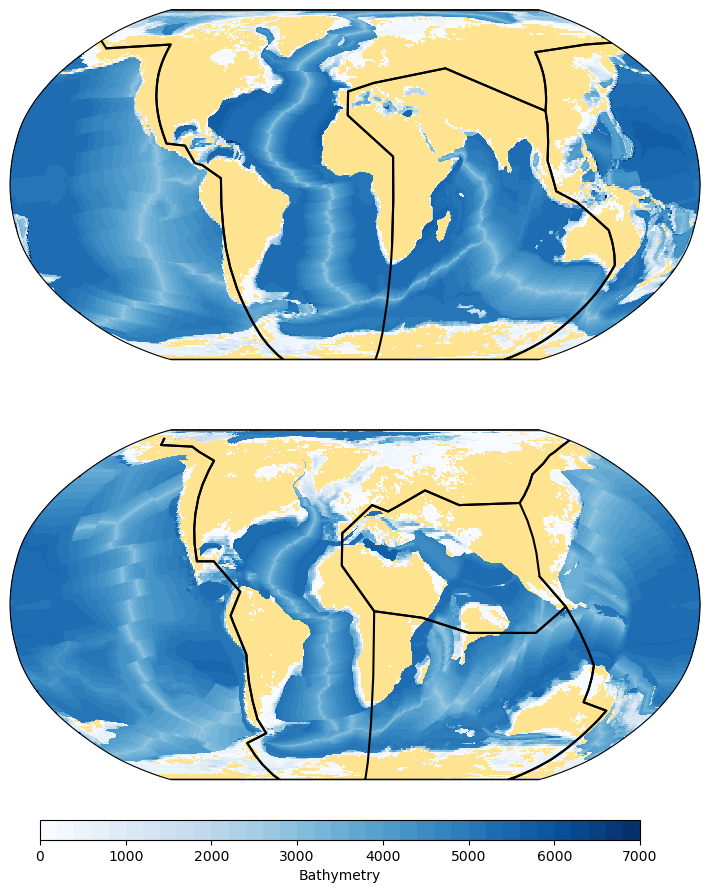

In [1]:
#################################################
#################### Imports ####################
#################################################

# For reading matlab files that store plate boundaries.
import scipy.io
import os

# For plotting
from netCDF4 import Dataset
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

###################################
## Define Functions for Figure  ###
###################################
def load_netcdf_data(age):
    # Read bathymetry file.
    ds = Dataset(os.getcwd()+'/PNAS_Bogumil_Results/bathymetryNCFiles/Bathymetry_{}Ma.nc'.format(age))

    # Assign data to variables
    lon, lat = np.meshgrid(ds['lon'][:], ds['lat'][:]);
    z = ds['z'][:].data;
    continents = ds['z'][:].mask;
    continentsnew = cp.deepcopy(continents).astype(float)
    continentsnew[continentsnew==0] = np.nan

    
    # Close dataset
    ds.close();
    
    # Return variables
    return lon, lat, z, continentsnew

def remove_non_unique_rows(arr):
    # Count occurrences of each row
    unique_rows, counts = np.unique(arr, axis=0, return_counts=True)
    # Only keep rows that appear once
    unique_only = unique_rows[counts == 1]
    return unique_only

def readBoundaries(age, pacificValues=[1,0]):
    # Load the .mat file
    mat_data = scipy.io.loadmat(os.getcwd()+'/PNAS_Bogumil_Results/basinPolygons/Earth{}Ma_basin_poly.mat'.format(age))

    # Print variable names in the file (ignoring MATLAB metadata entries)
    variable_names = [key for key in mat_data.keys() if not key.startswith('__')]
    #print("Variables in .mat file:", variable_names);

    # Access a specific variable (replace 'your_variable_name' as needed)
    boundaries = mat_data['Earth{}Ma'.format(age)][0][0];
    
    # Merge two Pacific boundaries
    if pacificValues is not None:
        x = np.vstack( (boundaries[pacificValues[0]], boundaries[pacificValues[1]]) )
        x = remove_non_unique_rows(x)
        boundariesOut = np.array(np.arange(len(boundaries)-1), dtype=object)
        boundariesOut[0] = x

        cnt = 0;
        for i in range(len(boundaries)):
            #print(i, (pacificValues[0]==i), (pacificValues[1]==i), ((pacificValues[0]==i) | (pacificValues[1]==i)))
            if not ((pacificValues[0]==i) | (pacificValues[1]==i)):
                #print(i)
                boundariesOut[cnt+1] = boundaries[i]
                boundariesOut[cnt+1] = boundaries[i]
                cnt+=1;
    else:
        boundariesOut = np.array(np.arange(len(boundaries)), dtype=object)
        for i in range(len(boundaries)):
            boundariesOut[i] = boundaries[i]
        

    return boundariesOut



############################################################################
# Read and plot bathymetry and basin boundaries from Bogumil et al. (2024) #
############################################################################

# Load NetCDF file
age1 = 0; age2 = 60;
lon, lat, z1, continents1 = load_netcdf_data(age1)
lon, lat, z2, continents2 = load_netcdf_data(age2)

# Load basin boundaries
boundaries1 = readBoundaries(age1, None)
boundaries2 = readBoundaries(age2, None)

# Reduce resolution
factor = 1
lon = lon[::factor].T[::factor].T
lat = lat[::factor].T[::factor].T
z1  = z1[::factor].T[::factor].T
z2  = z2[::factor].T[::factor].T
continents1 = continents1[::factor].T[::factor].T
continents2 = continents2[::factor].T[::factor].T


# Create the figure
## Set up projection and figure
proj = ccrs.Robinson()
fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 10),
    subplot_kw={'projection': proj},
    constrained_layout=False
)

# Define common color scale
vmin = np.nanmin([np.nanmin(z1), np.nanmin(z2)])
vmax = np.nanmax([np.nanmax(z1), np.nanmax(z2)])
vmin = 0
vmax = 7000


# Example polygon (replace with your actual lat/lon)
poly_lats = [-10, -10, 0, 0, -10]
poly_lons = [100, 110, 110, 100, 100]
polygon = Polygon(zip(poly_lons, poly_lats))

# Sample reversed blue cmap for bathymetry
N = 35
blues_cm = mpl.colormaps['Blues'].resampled(N)

# Plot first dataset
## Plot bathymetry
mesh11 = axs[0].pcolormesh(lon, lat, z1, transform=ccrs.PlateCarree(), cmap=blues_cm, shading='auto', vmin=vmin, vmax=vmax)
## Plot Land
mesh12 = axs[0].pcolormesh(lon, lat, continents1, transform=ccrs.PlateCarree(), cmap='YlOrBr', shading='auto', vmin=0, vmax=4)
## Plot basin boundaries
colors = ['black', 'black', 'black', 'black', 'black']

#colors = ['black', 'black', 'red', 'green']
cnt=0
for boundary in boundaries1:
    lonB = boundary[:,0]
    latB = -1*boundary[:,1]
    latB[latB > 90] = 90;
    latB[latB < -90] = -90;
    lonB[lonB > 180] = 180;
    lonB[lonB < -180] = -180;

    polygon1 = Polygon(zip(lonB, latB))
    colori = colors[cnt]
    axs[0].plot(lonB, latB, linestyle='solid', color=colori, transform=ccrs.PlateCarree())
    #axs[0].add_geometries([polygon1], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=colori, linewidth=2)
    cnt+=1;


# Plot second dataset
## Plot bathymetry
mesh21 = axs[1].pcolormesh(lon, lat, z2, transform=ccrs.PlateCarree(), cmap=blues_cm, shading='auto', vmin=vmin, vmax=vmax)
## Plot Land
mesh22 = axs[1].pcolormesh(lon, lat, continents2, transform=ccrs.PlateCarree(), cmap='YlOrBr', shading='auto', vmin=0, vmax=4)
## Plot basin boundaries
#colors = ['black', 'black', 'blue', 'red', 'white']
cnt=0
for boundary in boundaries2:
    lonB = boundary[:,0]
    latB = -1*boundary[:,1]
    
    latB[latB > 90] = 90;
    latB[latB < -90] = -90;
    lonB[lonB > 180] = 180;
    lonB[lonB < -180] = -180;

    polygon1 = Polygon(zip(lonB, latB))
    colori = colors[cnt]
    axs[1].plot(lonB, latB, linestyle='solid', color=colori, transform=ccrs.PlateCarree())
    #axs[1].add_geometries([polygon1], crs=ccrs.PlateCarree(), facecolor='none', edgecolor=colori, linewidth=2)
    cnt+=1;


# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(mesh21, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Bathymetry")

# Save figure
directory_name = os.getcwd()+"/figures/GMD_Manuscript/CodeOutputs/Bogumil_etal_2024_Bathymetry_and_BasinBoundaries"
os.makedirs(directory_name, exist_ok=True)

plt.savefig(directory_name+"/0_60Ma_Bathymetry_and_BasinBoundaries.png", dpi=600, transparent=True)


# Figure 2: Collection of free handdrawn basin boundaries used in previous studies (See FinalizedFigures folder)

# Figure 3: Diagram of Basin Detection Algorithm Workflow (See FinalizedFigures folder)

# Figure 4: Diagrams used to construct Girvan-Newman and Louvain Algorithm Diagram Figure (See FinalizedFigures folder for Composite Figure)

Removing edge from node pair 5-6
Removing edge from node pair 5-6
Removing edge from node pair 1-2
Removing edge from node pair 5-6
Removing edge from node pair 1-2
Removing edge from node pair 0-3
Removing edge from node pair 5-6
Removing edge from node pair 1-2
Removing edge from node pair 0-3
Removing edge from node pair 4-7


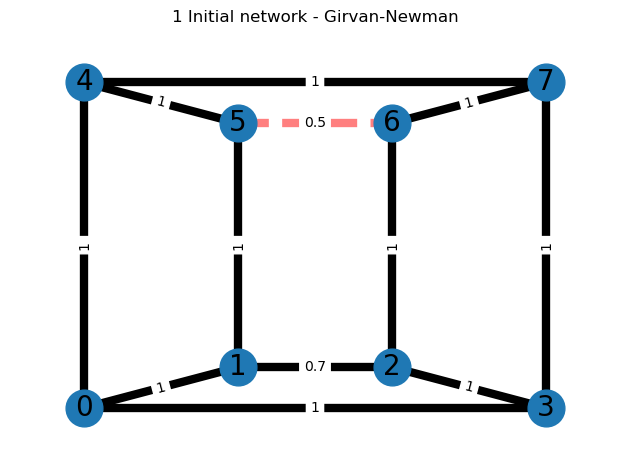

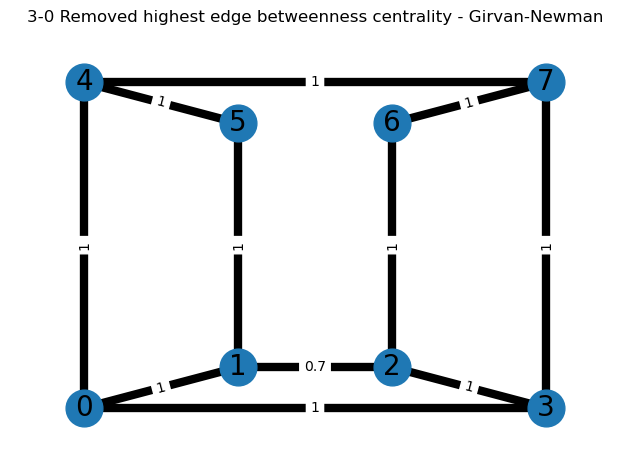

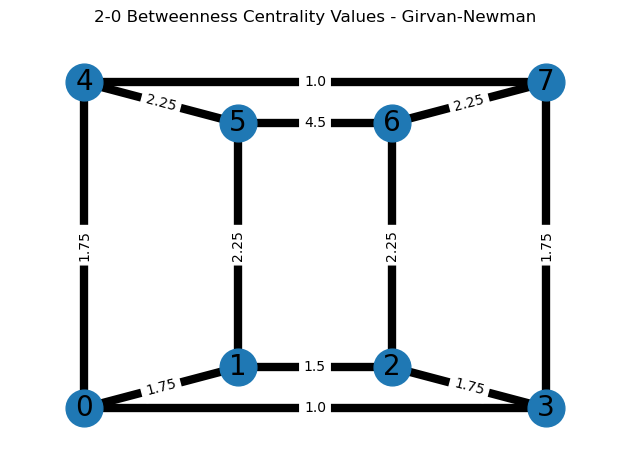

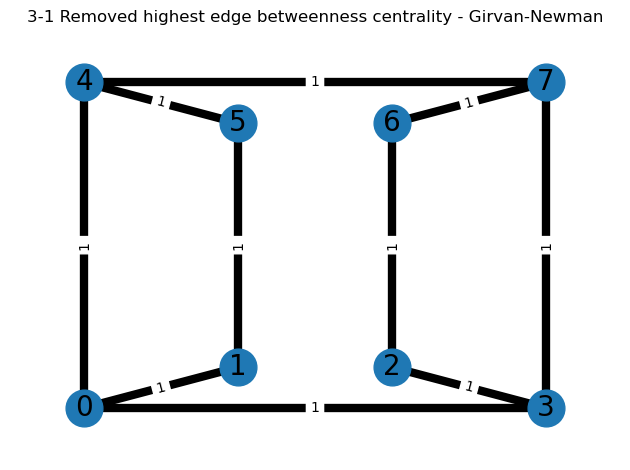

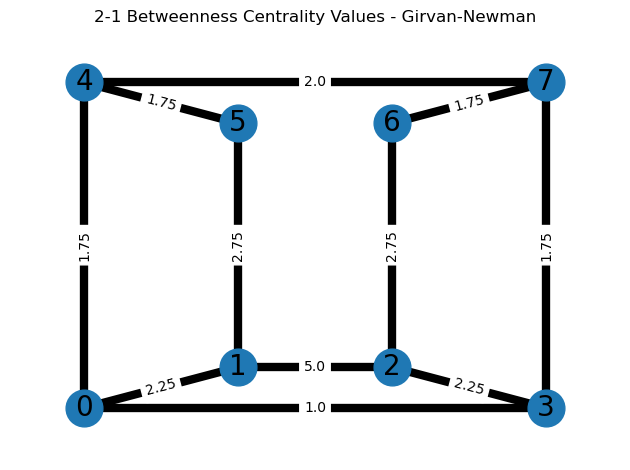

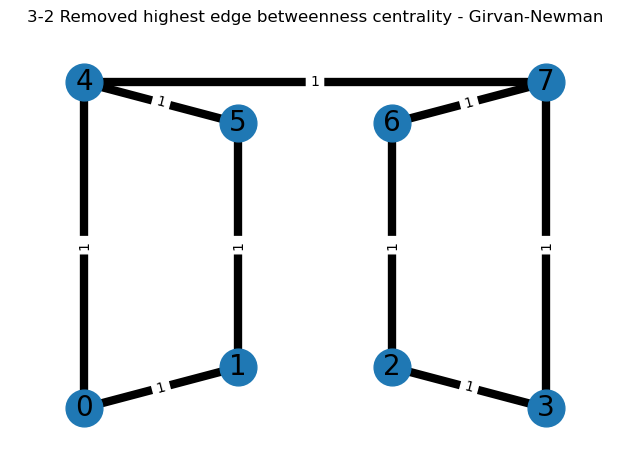

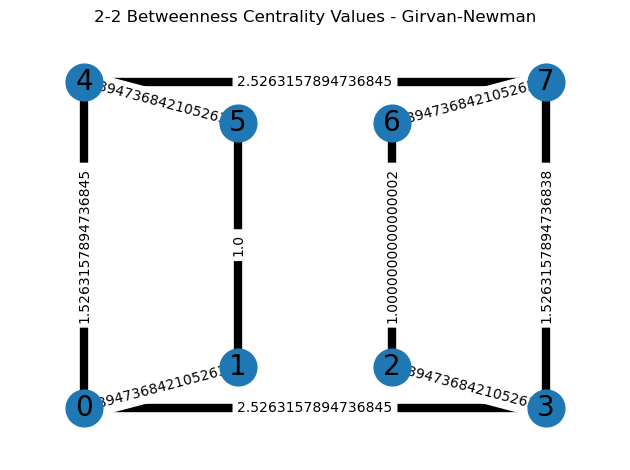

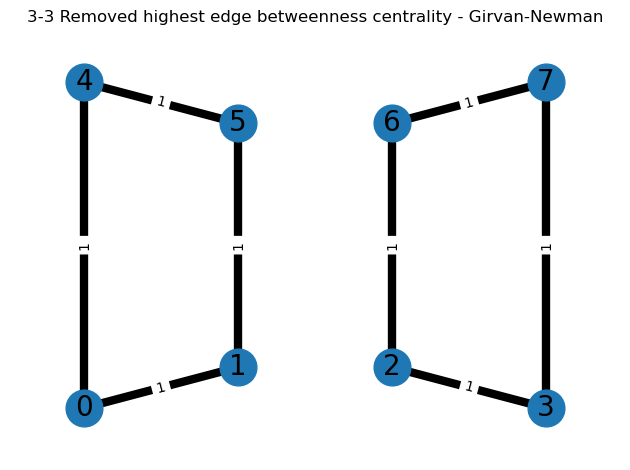

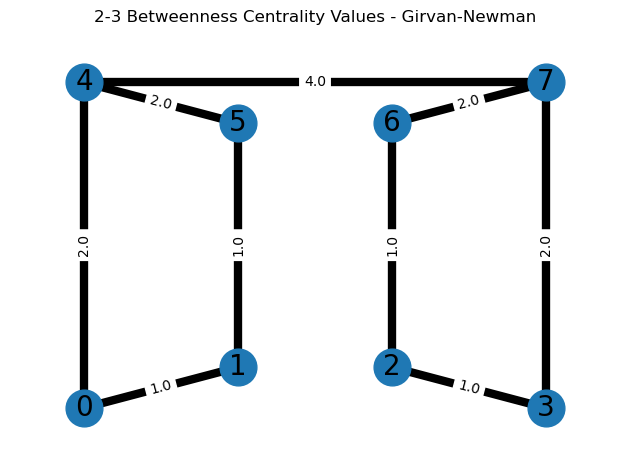

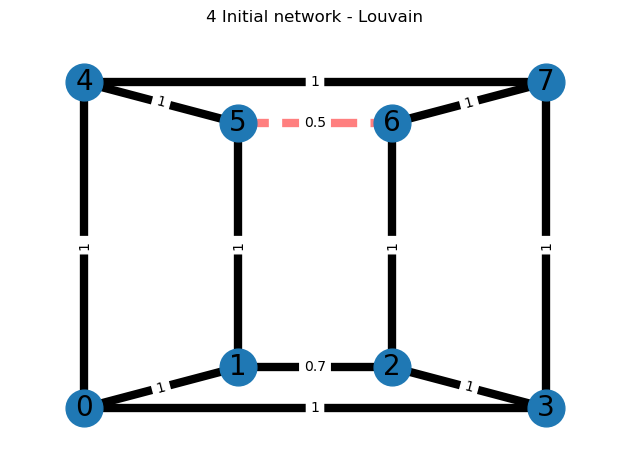

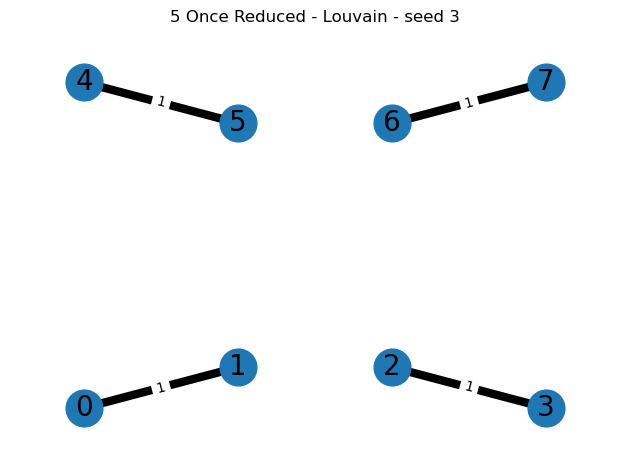

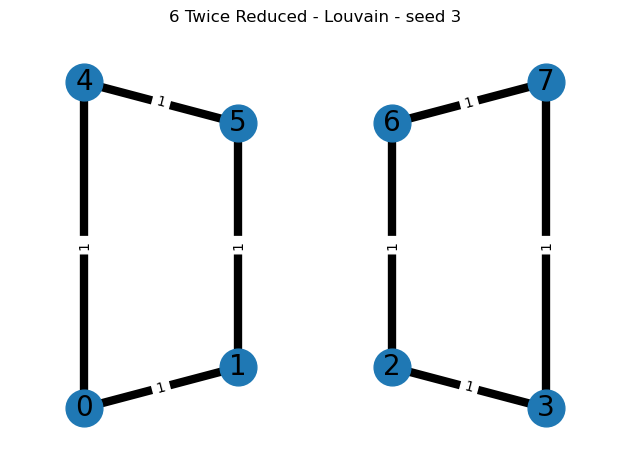

In [6]:
#################################################
#################### Imports ####################
#################################################
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Create the directory if it doesn't exist
directory_name = os.getcwd()+"/figures/GMD_Manuscript/CodeOutputs/GN_L_Algorithm";
os.makedirs(directory_name, exist_ok=True)


###################################
## Define Functions for Figure 2 ##
###################################
class NeighborNetwork():
    """
    createNeighborNetwork is a function designed
    to create an networkx spatial graph with neighbor
    node edges. Node edges are given a value of 1,
    but can be modified using a method.
    
    """
    
    def __init__(self, size=(2,8)):
        """
        Initializes NeighborNetwork.
        
        Parameters
        -----------
        size : TUPLE
            A tuple describing the size of the output
            graph. The graph will have size[0]*size[1]
            nodes.
        """
        # Construct new graph
        self.G = nx.Graph()
        
        # Add nodes
        ## Create numpy array of input size
        rows = size[0]
        cols = size[1]
        self.XX, self.YY = np.meshgrid(np.arange(cols), np.arange(rows))
        
        # Create nodes
        self.pos = [];
        for x, y in zip(self.XX.flatten(), self.YY.flatten()):
            currentNodeid = x + y*cols;
            self.G.add_node(currentNodeid, pos=(x-(cols-1)/2,
                                                (y-(rows-1)/2)*np.abs(0.4*(x-(cols-1)/2))+(y-(rows-1)/2))
                           )
            self.pos.append(currentNodeid)
        self.pos=np.array(self.pos);
        
        # Iterate over each nodes' xy position adding edges
        # adding each edge.
        for x, y in zip(self.XX.flatten(), self.YY.flatten()):
            # Positions
            #               X + Y*(# of columns) 
            currentNodeid = x + y*cols;
            leftid        = x + y*cols - 1;
            aboveid       = x + (y-1)*cols
            
            # Add edges to other nodes            
            if (x > 0):
                # Make connection left
                self.G.add_edge(currentNodeid,leftid, weight=1)            
            if (y > 0):
                #print("below\t", x, y, currentNodeid, aboveid)
                # Make connection below
                self.G.add_edge(currentNodeid,aboveid, weight=1)
                
            # Add edges to other nodes            
            if (x == 0):
                # Make connection left
                self.G.add_edge(currentNodeid,leftid+cols, weight=1)            
                
                
    def plot(self, title="Initial network", saveFig=True):
        elarge = [(u, v) for (u, v, d) in self.G.edges(data=True) if d["weight"] > .5]
        esmall = [(u, v) for (u, v, d) in self.G.edges(data=True) if d["weight"] <= .5]
        
        pos = nx.get_node_attributes(myNeighborNetwork.G, "pos")
        
        # Create new figure
        fig = plt.figure()

        # nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=700)

        # edges
        nx.draw_networkx_edges(self.G, pos, edgelist=elarge, width=6)
        nx.draw_networkx_edges(
            self.G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="r", style="dashed"
        )

        # node labels
        nx.draw_networkx_labels(self.G, pos, font_size=20, font_family="sans-serif")
        # edge weight labels
        edge_labels = nx.get_edge_attributes(self.G, "weight")
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels)

        ax = plt.gca()
        plt.title(title)
        ax.margins(.1)
        plt.axis("off")
        plt.tight_layout()
        if saveFig:
            plt.savefig(directory_name+"/"+title+".svg", dpi=600)

# Girvan-newman algorithm 
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight="weight")
    return max(centrality, key=centrality.get)

# Function that removes highest between edges removeNEdges times.
def girvanNewmanBetweennessDiagram(removeNEdges=1):
    # Make graph ()
    myNeighborNetwork = NeighborNetwork(size=(2,4))
    ## Change edge attributes
    myNeighborNetwork.G.edges[5,6]['weight'] = .5
    myNeighborNetwork.G.edges[1,2]['weight'] = .7

    # Plot again (removed most central edge)
    for i in range(removeNEdges):
        u,v = most_central_edge(myNeighborNetwork.G)
        centrality = nx.edge_betweenness_centrality(myNeighborNetwork.G, weight="weight")
        print("Removing edge from node pair {}-{}".format(u,v))
        myNeighborNetwork.G.remove_edge(u,v)
        
        
    myNeighborNetwork.plot(title="3-{} Removed highest edge betweenness centrality - Girvan-Newman".format(i))


    # Plot again (change edge values to centrality values)

    ## Set node edges to have betweenness centrality value
    list(centrality.values())/ np.min(list(centrality.values()))
    for nodes in centrality:
        myNeighborNetwork.G.add_edge(nodes[0],
                                     nodes[1],
                                     weight=centrality[nodes]/np.min(list(centrality.values())))

    myNeighborNetwork.plot(title="2-{} Betweenness Centrality Values - Girvan-Newman".format(i))
        

###############################
### Girvan-newman algorithm ###
###############################
# Make graph ()
myNeighborNetwork = NeighborNetwork(size=(2,4))
## Change edge attributes
myNeighborNetwork.G.edges[5,6]['weight'] = .5
myNeighborNetwork.G.edges[1,2]['weight'] = .7

# Plot graph
myNeighborNetwork.plot(title='1 Initial network - Girvan-Newman')


#############################################
### Girvan-newman algorithm removed edges ###
#############################################
# Remove one edge (1 community)
girvanNewmanBetweennessDiagram(1)
# Remove two edge (1 community)
girvanNewmanBetweennessDiagram(2)
# Remove three edge (1 community)
girvanNewmanBetweennessDiagram(3)
# Remove four edge (Creates 2 communities)
girvanNewmanBetweennessDiagram(4)


###############################
###### Louvain algorithm ######
###############################
# Make graph ()
myNeighborNetwork = NeighborNetwork(size=(2,4))

commL = nx.community.louvain_communities(myNeighborNetwork.G, weight='weight', max_level=20)

## Change edge attributes
# myNeighborNetwork.G.remove_edge(4,5)
# myNeighborNetwork.G.remove_edge(5,6)
# myNeighborNetwork.G.remove_edge(6,7)
# myNeighborNetwork.G.remove_edge(7,4)

# myNeighborNetwork.G.remove_edge(0,1)
# myNeighborNetwork.G.remove_edge(1,2)
# myNeighborNetwork.G.remove_edge(2,3)
# myNeighborNetwork.G.remove_edge(3,0)

# myNeighborNetwork.G.remove_edge(4,0)
# myNeighborNetwork.G.remove_edge(5,1)
# myNeighborNetwork.G.remove_edge(6,2)
# myNeighborNetwork.G.remove_edge(7,3)

###################################
## Define Functions for Figure 2 ##
###################################
def remove_intercommunity_edges(G, communities):
    """
    Removes all edges between communities in the graph G.

    Parameters:
    - G: A NetworkX graph (can be directed or undirected)
    - communities: A list of sets, each set contains nodes in one community
                   (e.g., output of nx.community.louvain_communities)

    Returns:
    - G_sub: A copy of G with only intra-community edges retained
    """
    # Create a copy to avoid modifying the original graph
    G_sub = G.copy()
    
    # Build a node to community index map
    node_to_comm = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            node_to_comm[node] = idx

    # Identify and remove inter-community edges
    edges_to_remove = []
    for u, v in G.edges():
        if node_to_comm.get(u) != node_to_comm.get(v):
            edges_to_remove.append((u, v))

    G_sub.remove_edges_from(edges_to_remove)
    return G_sub


###############################
###### Louvain algorithm ######
###############################
# Make graph ()
myNeighborNetwork1 = NeighborNetwork(size=(2,4))
myNeighborNetwork2 = NeighborNetwork(size=(2,4))

## Change edge attributes
myNeighborNetwork1.G.edges[5,6]['weight'] = .5
myNeighborNetwork1.G.edges[1,2]['weight'] = .7
myNeighborNetwork2.G.edges[5,6]['weight'] = .5
myNeighborNetwork2.G.edges[1,2]['weight'] = .7

## Find communities
seed = 3
commL1 = nx.community.louvain_communities(myNeighborNetwork1.G, weight='weight', threshold=.9, max_level=100, seed=seed)
commL2 = nx.community.louvain_communities(myNeighborNetwork2.G, weight='weight', threshold=.2, max_level=100, seed=seed)

## Find Louvain communities
modularity1 = nx.community.modularity(myNeighborNetwork1.G, commL1, weight='weight')
modularity2 = nx.community.modularity(myNeighborNetwork2.G, commL2, weight='weight')

# Plot graph - Initial graph
myNeighborNetwork1.plot(title='4 Initial network - Louvain', saveFig=True)

# Plot graph - Once reduced
## Removed all edge connections and add them where there are nodes forming communities
myNeighborNetwork1.G = remove_intercommunity_edges(myNeighborNetwork1.G, commL1)
## Plot
myNeighborNetwork1.plot(title='5 Once Reduced - Louvain - seed {}'.format(seed), saveFig=True)

# # Plot graph - Twice reduced
## Removed inter-community connections
myNeighborNetwork2.G = remove_intercommunity_edges(myNeighborNetwork2.G, commL2)
## Plot
myNeighborNetwork2.plot(title='6 Twice Reduced - Louvain - seed {}'.format(seed), saveFig=True)





# Figure 5: Prepare For Analysis by Downloading Etopo

In [ ]:
# Import necessary libraries
import ExoCcycle as EC
import matplotlib as mpl
import numpy as np
import os

# Create bathymetry object with body=... attributes
# Try setting body='mars' | 'earth' | 'moon', 'Venus'
body="Earth"
planetBathy = EC.Bathymetry.BathyMeasured(body=body)

# Create the directory if it doesn't exist
directory_name = os.getcwd()+"/topographies/{}".format(planetBathy.model)
os.makedirs(directory_name, exist_ok=True)

# Download topography model (note that is must only be done once per body).
# NOTE: UNCOMMENT THIS SECTION TO DOWNLOAD TOPOGRAPHY MODEL
planetBathy.getTopo(os.getcwd(),
                  verbose=True);

# Read topography. This method will generate a topography model netCDF4 file with 
# new_resolution, in degrees. Note that the generated topography model will be 
# cell registered (All calculations from here on out are in cell registered to
# simplify codes and reduce data loss on conversions).
planetBathy.readTopo(os.getcwd(),
                   new_resolution=1,
                   verbose=False);

# Generate a bathymetry model base on a set of input methods and properties. The setSeaLelvel
# method has multiple ways to fill topography with oceans. The two currently implemented at
# the time of this JN creation are as follows:
#     1) basinVolume : An option to define bathymetry by flooding topography with
#                      basinVolume['uncompactedVol'] amount of ocean water, in m3.
#     2) OceanArea : Option to define bathymetry by flooding topography until
#                    oceanArea['area'], decimal percent, of global area is covered
#                    with oceans.
# 
# Here, I use the OceanArea constraint and block the basinVolume constraint with comments.
# 
planetBathy.setSeaLevel(basinVolume = {"on":False, 'uncompactedVol':None},
                      oceanArea = {"on":True, "area":0.7},
                      isostaticCompensation = {"on":False}, verbose=False)

# Note that in this basinVolume example the uncompactedVol was set to the oceanArea
# bathymetry model's VOC, where oceanArea = {"on":True, "area":0.7}. 
#
# planetBathy.setSeaLevel(basinVolume = {"on":True, 'uncompactedVol':3.299187952154623e+17},
#                       oceanArea = {"on":False, "area":0.7},
#                       isostaticCompensation = {"on":False}, verbose=False)


# Save bathymetry model as netCDF4. Note that models will be saved under the same root folder
# that was supplied to the readTopo(...) method.
# 
# only the bathymetry array is saved in this file. Other relevant values are represented
# as vectors (e.g., lat, lon, area-weights, global bathymetery distributions, etc) or
# attributes (e.g., VOC, AOC, high latitude cutoff, etc).
# 
planetBathy.saveBathymetry()

#
# To see a full set of stored netCDF4 values, the user can uncomment the code below
# 
# planetBathy.readBathymetry()
# print(planetBathy.bathync)
# print(planetBathy.bathync.variables)

# Plot bathymetry model
blues_cm = mpl.colormaps['Blues'].resampled(100)
EC.utils.plotGlobal(planetBathy.lat, planetBathy.lon, planetBathy.bathymetry,
                    outputDir = planetBathy.data_dir+"/bathymetries/{}".format(planetBathy.model),
                    fidName = "{}-setSeaLevel_Area0p7.png".format(planetBathy.model),
                    cmapOpts={"cmap":blues_cm,
                              "cbar-title":"cbar-title",
                              "cbar-range":[np.nanmin(np.nanmin(planetBathy.bathymetry)),
                                            np.nanmean(planetBathy.bathymetry)+2*np.nanstd(planetBathy.bathymetry)]},
                    pltOpts={"valueType": "Bathymetry",
                             "valueUnits": "m",
                             "plotTitle":"{}".format(planetBathy.model),
                             "plotZeroContour":True},
                    savePNG = True)


# Plot bathymetry model w/ bathymetry histograms
EC.utils.plotGlobalwHist(planetBathy.lat, planetBathy.lon, planetBathy.bathymetry,
                        planetBathy.binEdges, planetBathy.bathymetryAreaDist_wHighlat, planetBathy.bathymetryAreaDist, planetBathy.highlatlat,
                        outputDir = planetBathy.data_dir+"/bathymetries/{}".format(planetBathy.model),
                        fidName = "{}-setSeaLevel_Area0p7.png".format(planetBathy.model),
                        cmapOpts={"cmap":blues_cm,
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[np.nanmin(np.nanmin(planetBathy.bathymetry)),
                                                np.nanmean(planetBathy.bathymetry)+2*np.nanstd(planetBathy.bathymetry)]},
                        pltOpts={"valueType": "Bathymetry",
                                 "valueUnits": "m",
                                 "plotTitle":"{}".format(planetBathy.model),
                                 "plotZeroContour":True},
                        savePNG = True)



# Figure 5: (Leiden Ensemble - Reduction On Etopo Bathymetry)

Makes two subplots:
- Etopo bathymetry map
- Leiden detected communities

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 12
Storing images in figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden_0

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4242.24it/s]


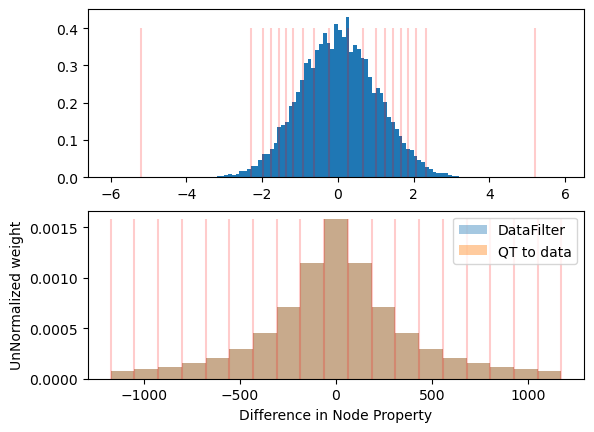

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 781.16it/s]


len(LDcommunities) 93
Network has been overwritten.


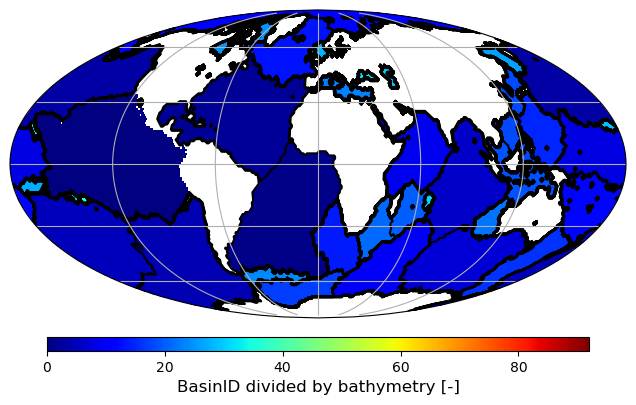

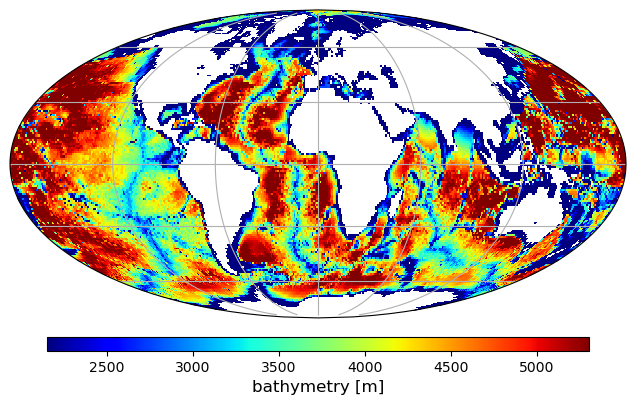

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
communityDetectionMethod = "Leiden"

# Define basin merging criteria
mergerPackageName = 'None'; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [12]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];

# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results    
    fldName = EC.utils.makeFolderSeries(fldBase='figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
    readmetxt += "\n{} ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);

    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)


# Figure 5: (Leiden Ensemble - Reduction and Girvan-Newman On Etopo Bathymetry)

Makes two subplots:
- Etopo bathymetry map
- Leiden-Girvan-Newman detected communities

Note that mergeSmallBasins is set to false, such that we can see the effect of Girvan-Newman mergers.
- basins.detectionMethod["mergerPackage"]["mergeSmallBasins"]["on"]=False

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 12
Storing images in figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden-GirvanNewman_0

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4220.05it/s]


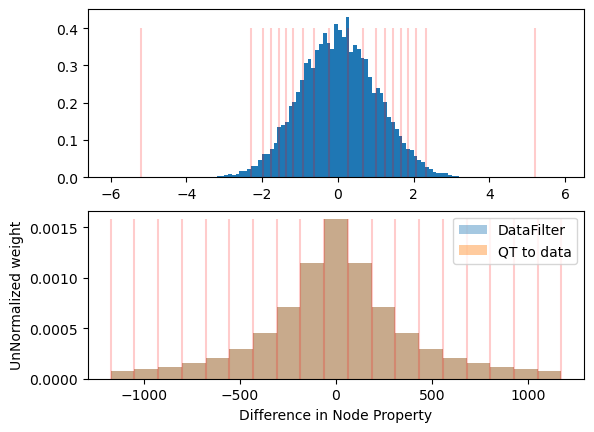

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 779.09it/s]


Girvan-Newman mergers such that 12 basins larger than 0.5 %


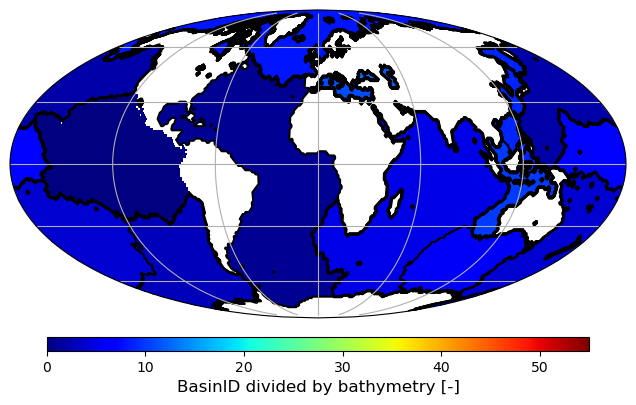

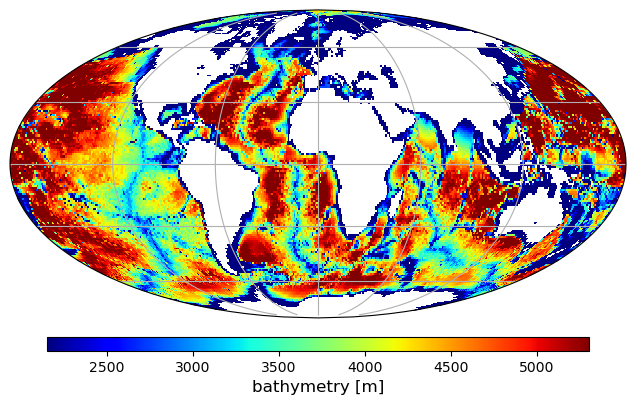

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
communityDetectionMethod = "Leiden-Girvan-Newman"

# Define basin merging criteria
mergerPackageName = "Lite"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [12]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":True,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results
    fldName = EC.utils.makeFolderSeries(fldBase='figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden-GirvanNewman')
    print("Storing images in {}".format(fldName))

    # Short readme text to write to folder with images
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
    readmetxt += "\n{} ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);


    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    # Note that mergeSmallBasins is set to false, such that we can see
    # the effect of Girvan-Newman mergers.
    mergerPackage["mergeSmallBasins"]["on"]=False
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)


# Figure 5: (Leiden Ensemble - Reduction, Girvan-Newman, and Post-Processing On Etopo Bathymetry)

Makes two subplots:
- Etopo bathymetry map
- Leiden-Girvan-Newman detected communities with merged small communities

Note that mergeSmallBasins is now always True, such that we can see the effect of Leiden-Girvan-Newman mergers plus the small basin mergers.


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.01 50 12
Storing images in figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden-GirvanNewman-PP_1

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4251.03it/s]


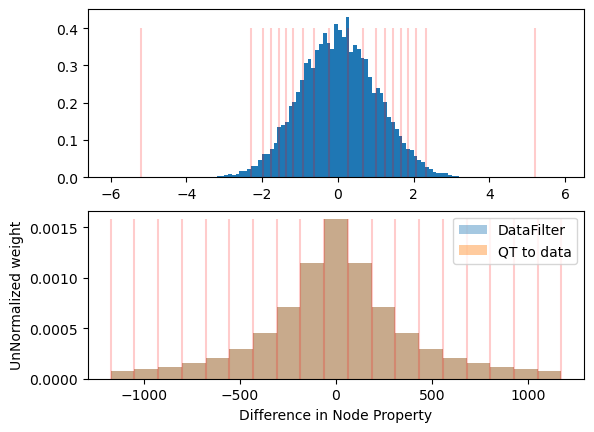

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 770.18it/s]


Girvan-Newman mergers such that 12 basins larger than 0.5 %
Network has been overwritten.
Network has been overwritten.


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


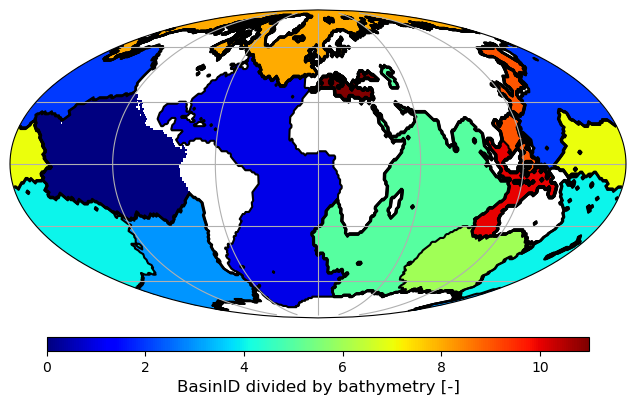

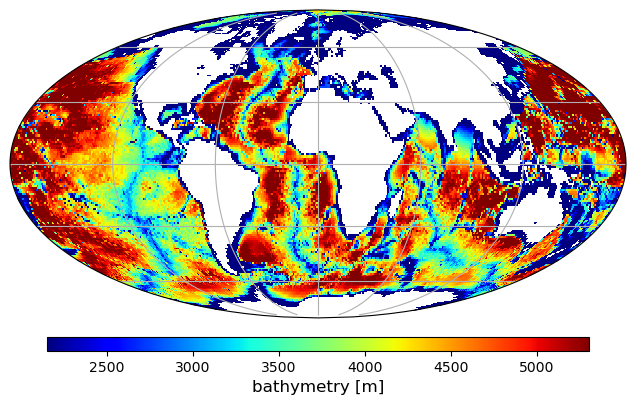

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset

# Create nodeclustering object
from cdlib import evaluation
from cdlib import NodeClustering

#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
communityDetectionMethod = "Leiden-Girvan-Newman"

# Define basin merging criteria
mergerPackageName = "Lite"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.01]

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [12]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":True,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results
    fldName = EC.utils.makeFolderSeries(fldBase='figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden-GirvanNewman-PP')
    print("Storing images in {}".format(fldName))
    
    # Short readme text to write to folder with images
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
    readmetxt += "\n{} ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);



    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)
    
    
    ###########################################
    ### Report community evaluation metrics ###
    ###########################################
    
    # Create node cluster
    # Note that the small basin mergers are not inlcuded
    # in the LGNClusters. Only large basin mergers such that
    # small basin mergers results in X chosen basins.
    LeidenClusters=NodeClustering(communities=basins.LDcommunities,
                           graph=basins.G,
                           method_name="consensus_ledien_fixed",
                           method_parameters={
                               "resolution_parameter": resolution,
                               "runs": ensembleSize,
                               "distance_threshold": 0.3}
                          )

    LGNClusters=NodeClustering(communities=basins.communitiesFinal,
                           graph=basins.G,
                           method_name="consensus_ledien_fixed",
                           method_parameters={
                               "resolution_parameter": resolution,
                               "runs": ensembleSize,
                               "distance_threshold": 0.3}
                          )


    # Calculate community detection metrics
    for cluster, method in zip([LeidenClusters, LGNClusters], ["LeidenClusters", "LGNClusters"]):
        newman_girvan_modularity = evaluation.newman_girvan_modularity(basins.G, cluster)
        internal_edge_density = evaluation.internal_edge_density(basins.G, cluster)
        erdos_renyi_modularity= evaluation.erdos_renyi_modularity(basins.G, cluster)
        modularity_density    = evaluation.modularity_density(basins.G, cluster)
        avg_embeddedness      = evaluation.avg_embeddedness(basins.G, cluster)
        conductance           = evaluation.conductance(basins.G, cluster)
        surprise              = evaluation.surprise(basins.G, cluster)

        # Add community evaluation metrics to output
        readmetxt += "\n\nCommunity evaluation metrics ({}):\n".format(method);
        readmetxt += "newman_girvan_modularity:\t {}\n".format(newman_girvan_modularity.score)
        readmetxt += "erdos_renyi_modularity:\t\t {}\n".format(erdos_renyi_modularity.score)
        readmetxt += "modularity_density:\t\t {}\n".format(modularity_density.score)
        readmetxt += "internal_edge_density:\t\t {} +- {} (std)\n".format(internal_edge_density.score, internal_edge_density.std)
        readmetxt += "avg_embeddedness:\t\t {} +- {} (std)\n".format(avg_embeddedness.score, avg_embeddedness.std)
        readmetxt += "conductance:\t\t\t {} +- {} (std)\n".format(conductance.score, conductance.std)
        readmetxt += "surprise:\t\t\t {}\n".format(surprise.score)
        
    
    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)


# Figure 5: Node locations for 1) Leiden Ensemble - Reduction and 2) Leiden Ensemble - Reduction and Girvan-Newman On Etopo Bathymetry

Makes two subplots:
- Node locations for initial global graph inputted into the Leiden Ensemble reduction step
- Node locations for the reduced Leiden Ensemble community structure

Storing images in figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden-GirvanNewman-PP-Nodes_0


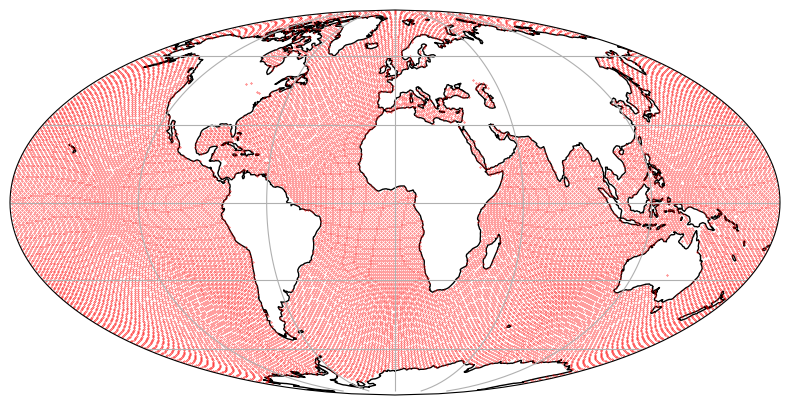

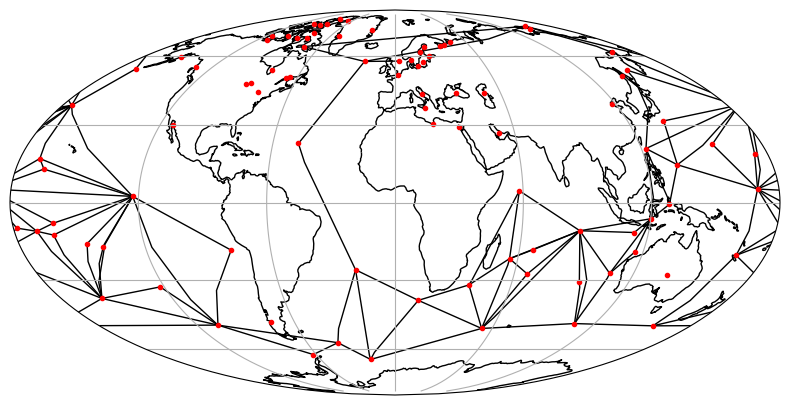

In [11]:
# Create node plot:
#     1) Base 1 degree resolution
#     2) Louvain community nodes (i.e., input to Girvan-Newman)
#
####################################################
### Define functions for plotting graph networks ###
####################################################
def split_antimeridian_line(lon1, lat1, lon2, lat2):
    """
    Split a line crossing the antimeridian into two segments,
    one in the eastern hemisphere and one in the western.

    Returns:
        western_segment: ((lon_a, lat_a), (lon_b, lat_b)) or None
        eastern_segment: ((lon_c, lat_c), (lon_d, lat_d)) or None
    """
    # Normalize longitudes to [-180, 180]
    lon1 = (lon1 + 180) % 360 - 180
    lon2 = (lon2 + 180) % 360 - 180

    if abs(lon2 - lon1) <= 180:
        # No crossing: return the full segment and None for the other
        if lon1 < 0:
            return ((lon1, lat1), (lon2, lat2)), None
        else:
            return None, ((lon1, lat1), (lon2, lat2))

    # Antimeridian crossing
    # Determine direction of crossing
    if lon1 > lon2:
        lon2 += 360
    else:
        lon1 += 360

    # Interpolation factor for crossing at 180°
    frac = (180 - lon1) / (lon2 - lon1)
    lat_mid = lat1 + frac * (lat2 - lat1)

    # First segment: lon1 -> 180°
    western_segment = ((lon1, lat1), (180, lat_mid))
    # Second segment: -180° -> lon2
    eastern_segment = ((180, lat_mid), (lon2, lat2))

    return western_segment, eastern_segment

def plotNodes(G, latitude, longitude,
              drawEdges=False, showSideEdges=True,
              markersize =.3,
              fidName='test.png', savePNG=False, saveSVG=False):
    
    # Imports
    import cartopy.crs as ccrs # type: ignore
    # Plot the network on a geographic map
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.Mollweide()})
    ax.set_global()

    # Draw the edges (connections)
    if drawEdges:
        for edge in G.edges(data=True):
            node1, node2, weight = edge
            lon1, lat1 = longitude[node1], latitude[node1]
            lon2, lat2 = longitude[node2], latitude[node2]
            cutoff = 90;
            if ((lon2<-cutoff) & (lon1>cutoff)) | ((lon1<-cutoff) & (lon2>cutoff)):
                # Node connection passes through antimeridian
                if showSideEdges:
                    #lats, lons = split_antimeridian([lon1, lon2], [lat1, lat2])
                    segment1, segment2 = split_antimeridian_line(lon1, lat1, lon2, lat2)
                    ax.plot([segment1[0][0],segment1[1][0]], [segment1[0][1],segment1[1][1]],
                            'k-', linewidth=1, transform=ccrs.PlateCarree())
                    ax.plot([segment2[0][0],segment2[1][0]], [segment2[0][1],segment2[1][1]],
                            'k-', linewidth=1, transform=ccrs.PlateCarree())
                pass
            else:
                # Node connection does not pass through antimeridian
                ax.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1, transform=ccrs.PlateCarree())
            
            
    # Draw the nodes (points) on the map
    ax.plot(longitude, latitude, 'ro', markersize=markersize, transform=ccrs.PlateCarree())  # longitude, latitude

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines()

    #plt.title("Geographic Network of points")
    
    # Save figure
    if savePNG:
        plt.savefig(fidName, dpi=600, transparent=True)
    if saveSVG:
        plt.savefig(fidName.replace(".png", ".svg"))

        
######################################
# Add details of community reduction #
######################################
        
# Make folder to hold figure results
fldName = EC.utils.makeFolderSeries(fldBase='figures/GMD_Manuscript/CodeOutputs/CompositeMethod_Leiden-GirvanNewman-PP-Nodes')
print("Storing images in {}".format(fldName))

# Short readme text to write to folder with images
readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
readmetxt += "\nUsing S/distanceV edge weight";
readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
readmetxt += "\nThe CDF used for S is calculated as follows:";
readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
readmetxt += "\n{} ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);
    
    
with open(fldName+"/readme.txt", "w") as text_file:
    text_file.write(readmetxt)

###############################
# 1) Base 1 degree resolution #
###############################
# Define node locations (latitude/longitude)
baseNodesLat = np.array([],dtype=float);
baseNodesLon = np.array([],dtype=float);
for x in basins.G:
    baseNodesLat = np.append(baseNodesLat, basins.G.nodes[x]['pos'][0])
    baseNodesLon = np.append(baseNodesLon, basins.G.nodes[x]['pos'][1])


plotNodes(basins.G, baseNodesLat, baseNodesLon,
          drawEdges=False, showSideEdges=False,
          fidName=fldName+'/BaseNodes.png',
          savePNG=True)


#############################################################
# 2) Louvain community nodes (i.e., input to Girvan-Newman) #
#############################################################
import copy as cp
LNodesLat = np.array([],dtype=float);
LNodesLon = np.array([],dtype=float);

for x in basins.Gnew:
    # Set nodes idx that are compiled into new nodes for
    # girvan-newman algorithm
    nodesInGnew = np.array(list(basins.LDcommunities[x]), dtype=np.int32)
    # Set average latitude and longitude of nodes in louvain community
    cutoff = 90;
    if (np.min(baseNodesLon[nodesInGnew])<-cutoff) & (np.max(baseNodesLon[nodesInGnew])>cutoff):
        # At the -180,180 boundary find the mean latitude/longitude
        # A mean is fine since nodes represent equal area quadrangles.
        Lons = cp.deepcopy(baseNodesLon[nodesInGnew]);
        Lons[Lons<0] += 360;
        aveLon = np.mean(Lons)
        if aveLon>180:
            aveLon -=360;
    else:
        aveLon = np.mean(baseNodesLon[nodesInGnew])
    
    LNodesLat = np.append(LNodesLat, np.mean(baseNodesLat[nodesInGnew]) )
    LNodesLon = np.append(LNodesLon, aveLon )


#########################
### Plot input fields ###
#########################
plotNodes(basins.Gnew, LNodesLat, LNodesLon,
          drawEdges=True, showSideEdges=True,
          markersize =3,
          fidName=fldName+'/LeidenCommunityNodes.png',
          savePNG=True)


# Figure 6: Weight Construction Using the DQT-CDF Method

This method is described in the text

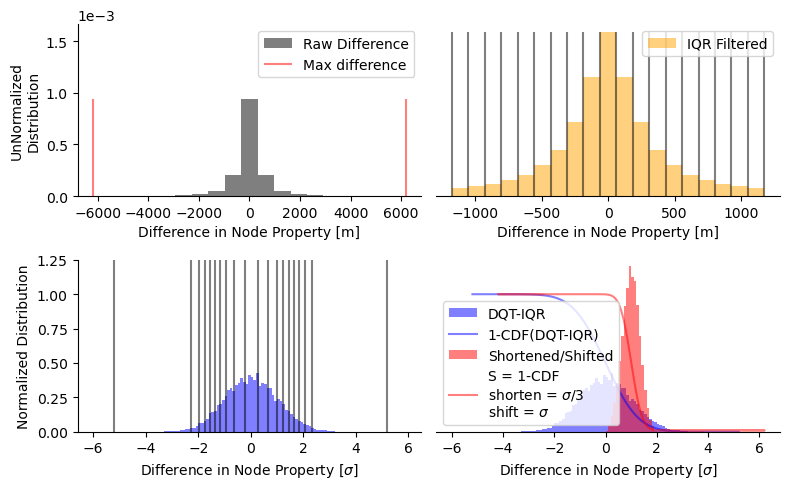

In [29]:
########################################################
#### Define functions to show weight scheme process ####
########################################################
# Scheme processes
# 1. Create distribution of absolute value differences between adjacent node  
# 2. Mirror distribition about 0 difference value (D)
# 3. IQR filter to remove outliers (D_{filter})
# 4. Normally distribute the using a data quantile transformation (D_{QT}) 
# 5. Construct shorten and shifted distribution and cumulative density function
# 6. Plot everything to construct manuscript figure

def createDataTreatmentFigures(basins, field,
                               RawDiff=True, IQRFilter=True,  QT=True, QT2=True, QT_CDF=True, 
                               compiledFig=True,
                               savePNG=False, saveSVG=False, directory=os.getcwd()):
    """
    createDataTreatmentFigures create figures to
    visualize the data treatment process in making
    graph edge weights.
    
    Parameters
    -----------
    RawDiff : BOOLEAN
        Plot a distribution of the raw differences
        between connected nodes within the graph.
    IQRFilter : BOOLEAN
        Plot a distribution of the IQR filtered
        differences between connected nodes within
        the graph.
    QT : BOOLEAN
        Plot a distribution of the IQR filtered
        and QT distributed differences between
        connected nodes within the graph.
    QT2 : BOOLEAN
        Similar to QT option.
    QT_CDF : BOOLEAN
        Plot a distribution of the QT distributed
        differences between connected nodes within
        the graph, with a overlay of the CDF function
        used to determine node edge weights.
    compiledFig : BOOLEAN
        2x2 subplots of A) raw difference, B) IQR filtered
        difference, C) DQT-IQR, D) Weight distributions with
        CDF lines.
    savePNG : BOOLEAN
        An option to plot PNGs.
    saveSVG : BOOLEAN
        An option to plot SVGs.
    directory : STRING
        An output directory for the saved figures.
    
    """
    # Set a directory / general name for figure naming convention.
    fidName = basins.Fields[field]['parameterName']
    
    ###################################
    ############# Imports #############
    ###################################
    from scipy.stats import norm
    from sklearn.preprocessing import QuantileTransformer
    
    
    ###################################
    ########## Create figures #########
    ###################################
    if RawDiff:
        # Define mirrored difference data
        xValues = np.append(basins.Fields[field]['dataEdgeDiff'], -basins.Fields[field]['dataEdgeDiff'])
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        
        # Plot subplot
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));

        # Compare original vs QT 
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='Raw Difference', density=True)
        plt.vlines(x=[np.min(xValues), np.max(xValues)],
                   ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2,
                   label='Max difference')
        
        # Formatting
        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.xlabel("Difference in Node Property");
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        
        # Save figure
        if savePNG:
            plt.savefig(directory+"RawDiff_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"RawDiff_{}.svg".format(fidName))
        
        
    if IQRFilter:
        # Define mirrored difference data
        xValues = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        
        # Plot subplot
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));

        # Compare original vs QT 
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='IQR Filtered', density=True)
        plt.vlines(x=[np.min(xValues), np.max(xValues)],
                   ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2,
                   label='Max difference')
        
        # Formatting
        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.xlabel("Difference in Node Property");
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        
        # Save figure
        if savePNG:
            plt.savefig(directory+"IQRFilter_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"IQRFilter_{}.svg".format(fidName))

        
    if QT:
        xValues = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        basins.Fields[field]['weightMethodPara']['qt'] = \
        QuantileTransformer(n_quantiles=1000,
                            random_state=0,
                            output_distribution='normal')
        qtDiss  = basins.Fields[field]['weightMethodPara']['qt'].fit_transform(np.reshape(xValues, (len(xValues),1)))

        # Create a set of equal space values in the data domain
        # These can be plotted on the gaussian domain to see the data stretching
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        binsqt = basins.Fields[field]['weightMethodPara']['qt'].transform(np.reshape(bins, (len(bins),1)))

        # Plot subplot
        fig, axes = plt.subplots(nrows=2, ncols=1);
        # QT distribution
        plt.sca(axes[1])
        plt.hist(qtDiss, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='IQR Filtered', density=True)
        plt.vlines(x=binsqt, ymin=0, ymax=1.25, colors='r', alpha=.2)

        # Compare original vs QT 
        plt.sca(axes[0])
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='IQR Filtered', density=True)
        plt.vlines(x=bins, ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2)
        qtxValues = basins.Fields[field]['weightMethodPara']['qt'].inverse_transform(qtDiss)
        plt.hist(qtxValues, alpha=.5, color='b', bins=bins, label='QT to data', density=True);

        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.sca(axes[1])
        plt.ylim([0,1.25])
        plt.ylabel("Normalized Distribution")
        plt.xlabel("Difference in Node Property [{}/std]".format(basins.Fields[field]['parameterUnit']));
        
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['bottom'].set_visible(False)
        
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        
        # Save figure
        if savePNG:
            plt.savefig(directory+"QT_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"QT_{}.svg".format(fidName))
            
    if QT2:
        xValues = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        basins.Fields[field]['weightMethodPara']['qt'] = \
        QuantileTransformer(n_quantiles=1000,
                            random_state=0,
                            output_distribution='normal')
        qtDiss  = basins.Fields[field]['weightMethodPara']['qt'].fit_transform(np.reshape(xValues, (len(xValues),1)))

        # Create a set of equal space values in the data domain
        # These can be plotted on the gaussian domain to see the data stretching
        bins   = np.linspace(np.min(xValues), np.max(xValues), 20);
        binsqt = basins.Fields[field]['weightMethodPara']['qt'].transform(np.reshape(bins, (len(bins),1)))

        # Plot subplot
        fig, axes = plt.subplots(nrows=2, ncols=1);
        # QT distribution
        plt.sca(axes[1])
        plt.hist(qtDiss, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DQT-IQR', density=True)
        plt.vlines(x=binsqt, ymin=0, ymax=1.25, colors='r', alpha=.2)

        # Compare original vs QT 
        plt.sca(axes[0])
        hist = plt.hist(xValues, alpha=.5, color='crimson', bins=bins, label='IQR Filtered', density=True)
        plt.vlines(x=bins, ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.2)
        qtxValues = basins.Fields[field]['weightMethodPara']['qt'].inverse_transform(qtDiss)
        #plt.hist(qtxValues, alpha=.5, color='b', bins=bins, label='QT to data', density=True);

        plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.sca(axes[1])
        plt.legend();
        plt.ylim([0,1.25])
        plt.ylabel("Normalized Distribution")
        plt.xlabel("Difference in Node Property [{}/std]".format(basins.Fields[field]['parameterUnit']));
        
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['bottom'].set_visible(False)
        
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        
        # Save figure
        if savePNG:
            plt.savefig(directory+"QT_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"QT_{}.svg".format(fidName))
        
        
    if QT_CDF:
        # Set data as IQRFiltered that is mirrored on the at dataEdgeDiffIQRFiltered=0
        # (no difference in adjacent node values)
        xValuesFiltered = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'],
                                    -basins.Fields[field]['dataEdgeDiffIQRFiltered'])

        # Create QT object and fit
        qt = QuantileTransformer(n_quantiles=1000, random_state=0,  output_distribution='normal')
        x  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

        # Use the QT to convert the xValuesFiltered difference data into z-score space. 
        xFiltered  = qt.fit_transform(np.reshape(xValuesFiltered, (len(xValuesFiltered),1)))

        # Define the cumulative density function in the z-score space. 
        stretchFactor = 3;
        qtDissSTD = 1
        cdfCenter  = qtDissSTD*1
        cdfStretch = qtDissSTD/stretchFactor
        normCDF = 1-1*norm.cdf(xFiltered, loc=0, scale=cdfStretch)
        normCDF2 = 1-1*norm.cdf(xFiltered, loc=0, scale=1)

        distribution = norm.ppf(normCDF.T[0], loc=cdfCenter, scale=cdfStretch/stretchFactor)


        ################################
        ############# Plot #############
        ################################
        # Plot subplot
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));


        
        # QT distribution
        plt.sca(axes)

        plt.hist(xFiltered, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DQT-IQR', density=True);
        sorted_indices = np.argsort(normCDF2.T[0])
        plt.plot(xFiltered[sorted_indices], normCDF2.T[0][sorted_indices], 'b-',  alpha=.5, label='1-CDF(DQT-IQR)');

        minWeight = 0.01;
        plt.hist(distribution, alpha=.5, color='r', bins=np.arange(-6, 6, .1), label='Shortened/Shifted', density=True);
        sorted_indices = np.argsort( (normCDF.T[0]+minWeight)/(1+minWeight) )
        plt.plot( (xFiltered+cdfCenter)[sorted_indices], ((normCDF.T[0]+minWeight)/(1+minWeight))[sorted_indices], 'r-',  alpha=.5,
                 label='S = 1-CDF\nshorten = $\sigma/{}$\nshift = $\sigma$'.format(stretchFactor));

        # Formatting
        plt.legend();
        plt.xlabel(r"Difference in Node Property $[\sigma]$");
        plt.ylabel("Normalized weight")
        plt.ylim([0,1.25])
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)

        # Save figure
        if savePNG:
            plt.savefig(directory+"QT_CDF_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"QT_CDF_{}.svg".format(fidName))
            
        
    if compiledFig:
        # 2x2 Subplots
        # A) raw difference
        # B) IQR filtered difference
        # C) DQT-IQR
        # D) Weight distributions with CDF lines.
        
        #############################
        ####### Create figure #######
        #############################
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,5));
        
        
        #########################
        ####### Subplot 1 #######
        #########################
        # Set axis
        plt.sca(axes[0][0])
        
        # Define mirrored difference data
        rawDiff = np.append(basins.Fields[field]['dataEdgeDiff'], -basins.Fields[field]['dataEdgeDiff'])
        bins   = np.linspace(np.min(rawDiff), np.max(rawDiff), 20);
        
        # Compare original vs QT 
        hist = plt.hist(rawDiff, alpha=.5, color='k', bins=bins, label='Raw Difference', density=True)
        plt.vlines(x=[np.min(rawDiff), np.max(rawDiff)],
                   ymin=0, ymax=np.max(hist[0]), colors='r', alpha=.5,
                   label='Max difference')
        
        # Formatting
        plt.ylabel("UnNormalized\nDistribution")

        # Plot formatting
        plt.legend();
        plt.xlabel("Difference in Node Property [m]");
        axes[0][0].spines['top'].set_visible(False)
        axes[0][0].spines['right'].set_visible(False)
        
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
        #########################
        #### For subplot 2/3 ####
        #########################
        IQRFiltered = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        basins.Fields[field]['weightMethodPara']['qt'] = \
        QuantileTransformer(n_quantiles=1000,
                            random_state=0,
                            output_distribution='normal')
        qtDiss  = basins.Fields[field]['weightMethodPara']['qt'].fit_transform(np.reshape(IQRFiltered, (len(IQRFiltered),1)))

        # Create a set of equal space values in the data domain
        # These can be plotted on the gaussian domain to see the data stretching
        bins   = np.linspace(np.min(IQRFiltered), np.max(IQRFiltered), 20);
        binsqt = basins.Fields[field]['weightMethodPara']['qt'].transform(np.reshape(bins, (len(bins),1)))

        #########################
        ####### Subplot 2 #######
        #########################
        # Set axis
        plt.sca(axes[0][1])
        
        # Define mirrored difference data
        IQRFiltered = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'], -basins.Fields[field]['dataEdgeDiffIQRFiltered'])
        bins   = np.linspace(np.min(IQRFiltered), np.max(IQRFiltered), 20);
        
        # Plot subplot
        #fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8/2));

        # Compare original vs QT 
        hist = plt.hist(IQRFiltered, alpha=.5, color='orange', bins=bins, label='IQR Filtered', density=True)
        plt.vlines(x=bins, ymin=0, ymax=np.max(hist[0]), colors='k', alpha=.5)
        qtxValues = basins.Fields[field]['weightMethodPara']['qt'].inverse_transform(qtDiss)
        
        # Formatting
        #axes[0][1].yaxis.set_label_position("right")
        #plt.ylabel("UnNormalized Distribution")

        # Plot formatting
        plt.legend();
        plt.xlabel("Difference in Node Property [m]");
        axes[0][1].spines['top'].set_visible(False)
        axes[0][1].spines['left'].set_visible(False)
        axes[0][1].spines['right'].set_visible(False)
        
        axes[0][1].set_yticks([])
        
        # Set subplot 1 ylim equal to subplot 2 ylim
        ymin, ymax = axes[0][1].get_ylim()
        axes[0][0].set_ylim(ymin=ymin, ymax=ymax)
        
        #########################
        ####### Subplot 3 #######
        #########################
        # Set axis
        plt.sca(axes[1][0])
        
        # QT distribution
        plt.hist(qtDiss, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DQT-IQR', density=True)
        plt.vlines(x=binsqt, ymin=0, ymax=1.25, colors='k', alpha=.5)

        # Plot formatting
        #plt.legend();
        plt.ylim([0,1.25])
        plt.ylabel("Normalized Distribution")
        plt.xlabel(r"Difference in Node Property $[\sigma]$");
        
        axes[1][0].spines['top'].set_visible(False)
        axes[1][0].spines['right'].set_visible(False)
        
                
        #########################
        ####### Subplot 4 #######
        #########################
        # Set axis
        plt.sca(axes[1][1])
        
        
        # Set data as IQRFiltered that is mirrored on the at dataEdgeDiffIQRFiltered=0
        # (no difference in adjacent node values)
        IQRFiltered = np.append(basins.Fields[field]['dataEdgeDiffIQRFiltered'],
                                -basins.Fields[field]['dataEdgeDiffIQRFiltered'])

        # Create QT object and fit
        qt = QuantileTransformer(n_quantiles=1000, random_state=0,  output_distribution='normal')
        x  = qt.fit_transform(np.reshape(IQRFiltered, (len(IQRFiltered),1)))

        # Use the QT to convert the xValuesFiltered difference data into z-score space. 
        xFiltered  = qt.fit_transform(np.reshape(IQRFiltered, (len(IQRFiltered),1)))

        # Define the cumulative density function in the z-score space. 
        stretchFactor = 3;
        qtDissSTD = 1
        cdfCenter  = qtDissSTD*1
        cdfStretch = qtDissSTD/stretchFactor
        normCDF = 1-1*norm.cdf(xFiltered, loc=0, scale=cdfStretch)
        normCDF2 = 1-1*norm.cdf(xFiltered, loc=0, scale=1)

        distribution = norm.ppf(normCDF.T[0], loc=cdfCenter, scale=cdfStretch/stretchFactor)
        
        # Plot
        plt.hist(xFiltered, alpha=.5, color='b', bins=np.arange(-6, 6, .1), label='DQT-IQR', density=True);
        sorted_indices = np.argsort(normCDF2.T[0])
        plt.plot(xFiltered[sorted_indices], normCDF2.T[0][sorted_indices], 'b-',  alpha=.5, label='1-CDF(DQT-IQR)');

        minWeight = 0.01;
        plt.hist(distribution, alpha=.5, color='r', bins=np.arange(-6, 6, .1), label='Shortened/Shifted', density=True);
        sorted_indices = np.argsort( (normCDF.T[0]+minWeight)/(1+minWeight) )
        plt.plot( (xFiltered+cdfCenter)[sorted_indices], ((normCDF.T[0]+minWeight)/(1+minWeight))[sorted_indices], 'r-',  alpha=.5,
                 label='S = 1-CDF\nshorten = $\sigma/{}$\nshift = $\sigma$'.format(stretchFactor));

        # Formatting
        plt.legend();
        plt.xlabel(r"Difference in Node Property $[\sigma]$");
        #plt.ylabel("Normalized weight")
        plt.ylim([0,1.25])
        axes[1][1].spines['top'].set_visible(False)
        axes[1][1].spines['right'].set_visible(False)
        axes[1][1].spines['left'].set_visible(False)
        
        axes[1][1].set_yticks([])

        # More formatting
        plt.tight_layout()
        
        # Save figure
        if savePNG:
            plt.savefig(directory+"Compiled_{}.png".format(fidName), dpi=600, transparent=True)
        if saveSVG:
            plt.savefig(directory+"Compiled_{}.svg".format(fidName))


            
#########################################
#### Run functions to create figures ####
#########################################
# Create the directory if it doesn't exist
directory_name = os.getcwd()+"/figures/GMD_Manuscript/CodeOutputs/DQT-CDF-WeightingMethod"
os.makedirs(directory_name, exist_ok=True)

# Create figures using field 1 data (etopo bathymetry)
field = 'Field1'
createDataTreatmentFigures(basins, field,
                           RawDiff=False, IQRFilter=False,  QT=False,
                           QT2=False, QT_CDF=False, compiledFig=True,
                           savePNG=True, saveSVG=True,
                           directory=directory_name+"/")


# Figure 7: 3x3 For X Changing Gamma Resolution=[0.01, 0.005, 0.015] and Y Ensemble Size [1, 10, 50] For Community Detection Using Leiden Only Method 

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.005 1 12
0.01 1 12
0.015 1 12
0.005 10 12
0.01 10 12
0.015 10 12
0.005 50 12
0.01 50 12
0.015 50 12
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_0

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4304.58it/s]


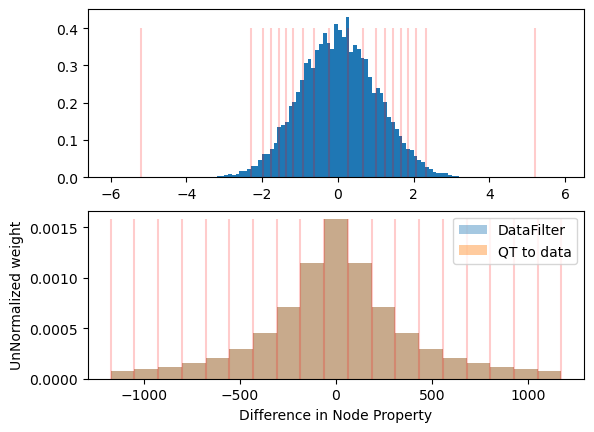

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 777.64it/s]


len(LDcommunities) 55
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_1

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4343.27it/s]


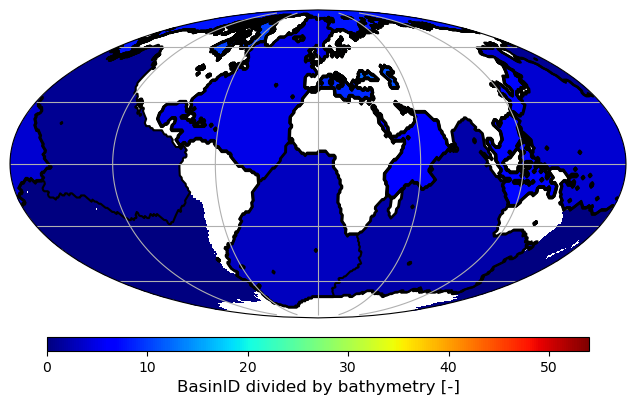

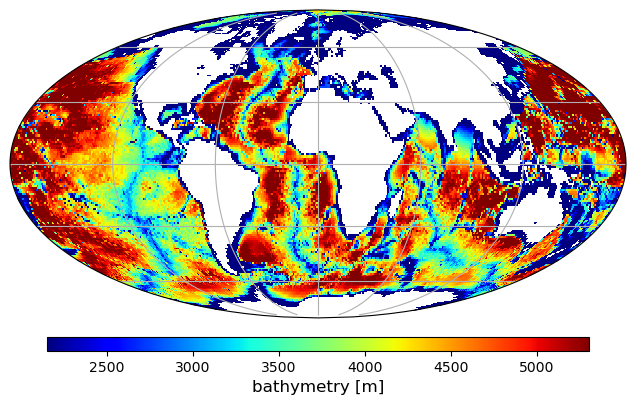

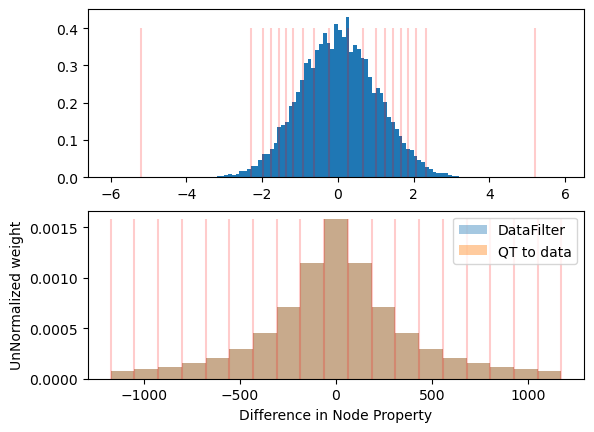

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 772.48it/s]


len(LDcommunities) 60
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_2

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4432.18it/s]


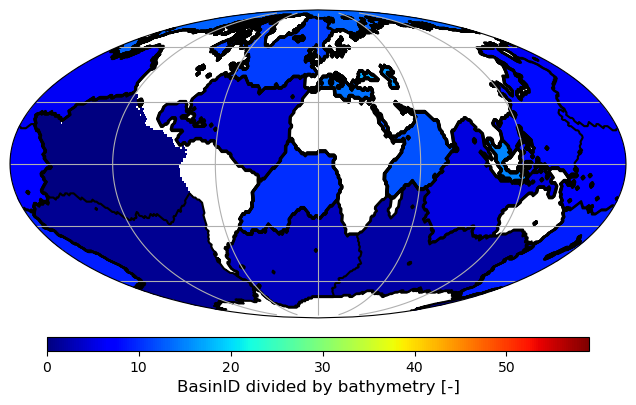

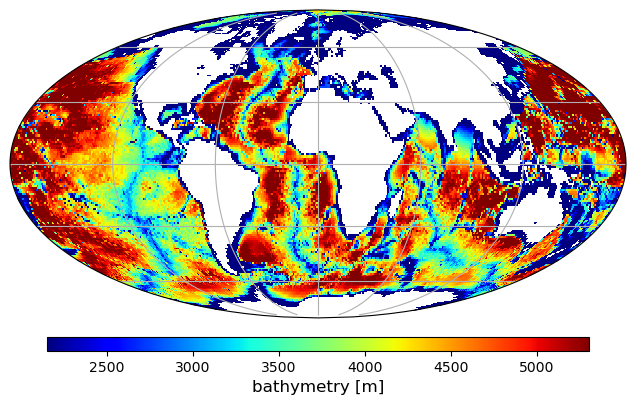

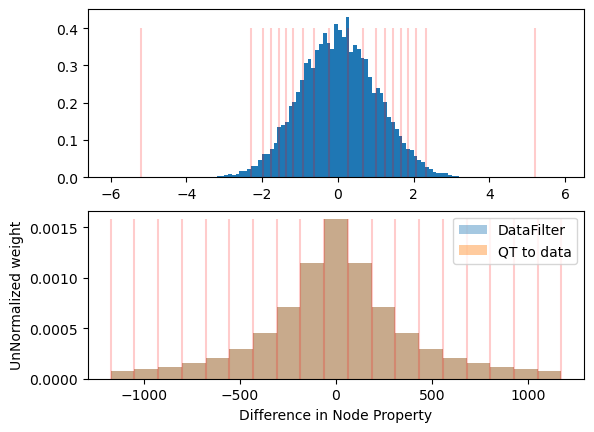

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 783.35it/s]


len(LDcommunities) 65
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_3

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4460.52it/s]


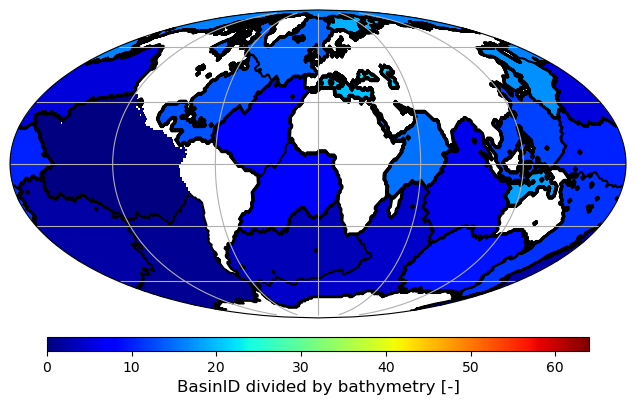

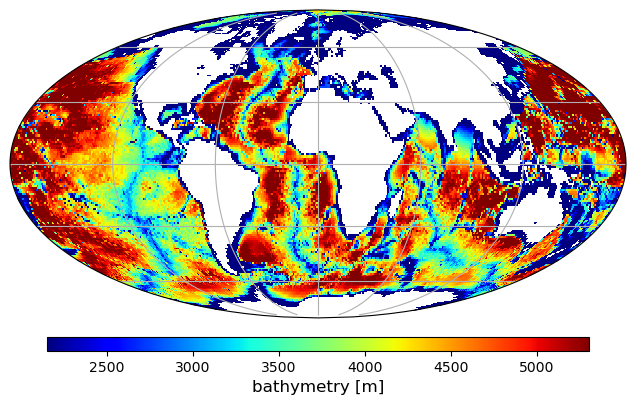

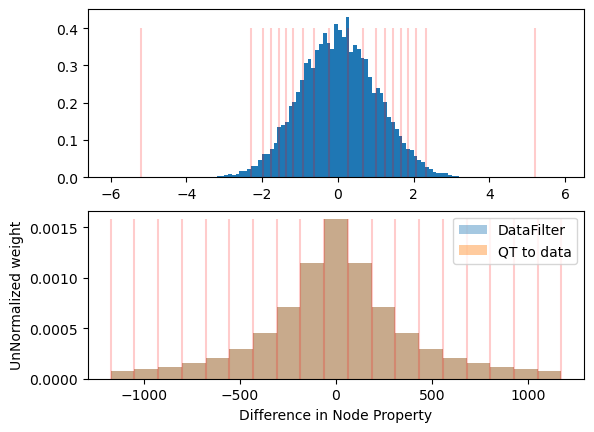

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 786.81it/s]


len(LDcommunities) 74
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_4

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4431.02it/s]


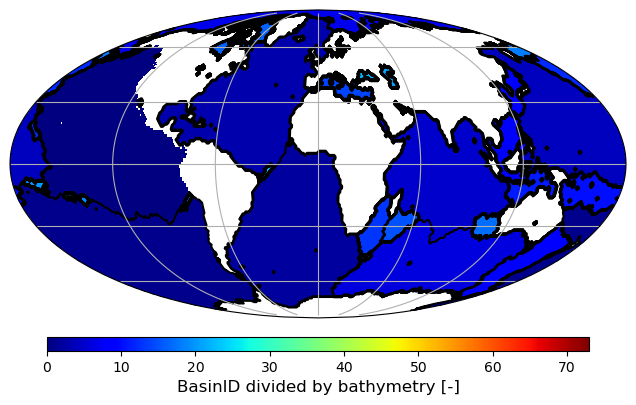

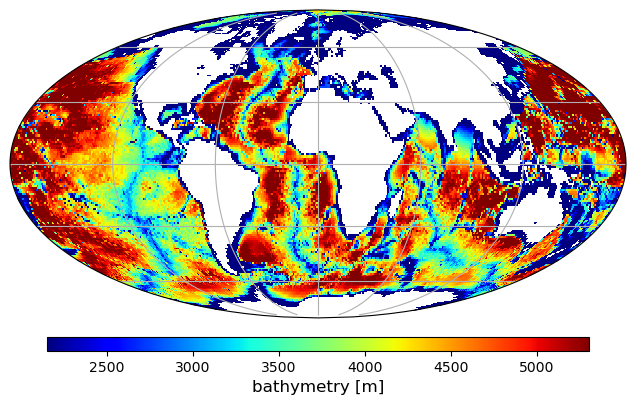

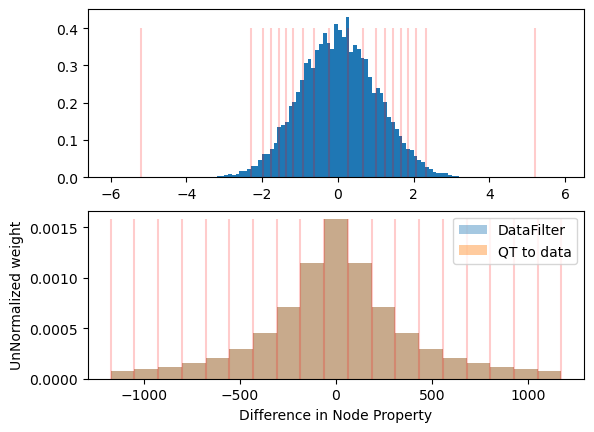

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 783.39it/s]


len(LDcommunities) 92
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_5

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4500.25it/s]


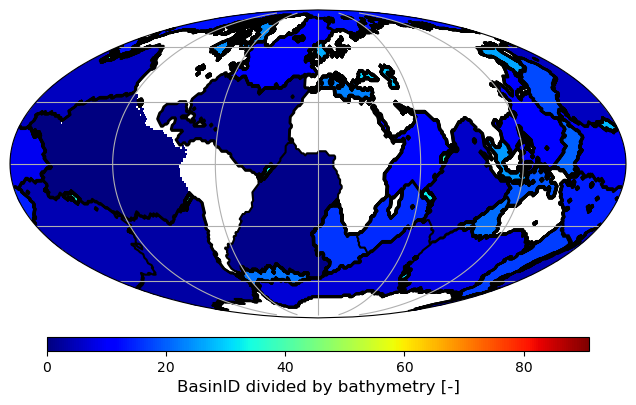

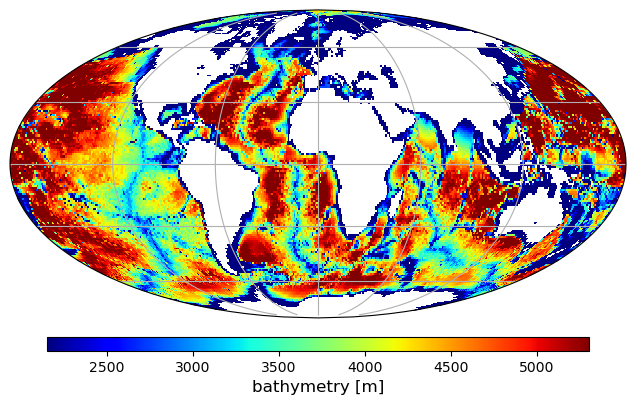

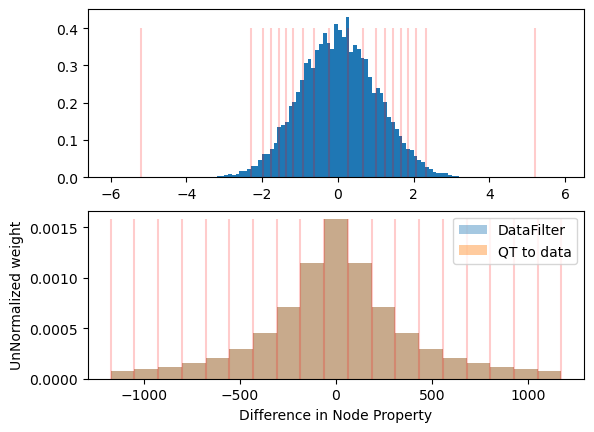

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 775.17it/s]


len(LDcommunities) 113
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_6

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4403.78it/s]


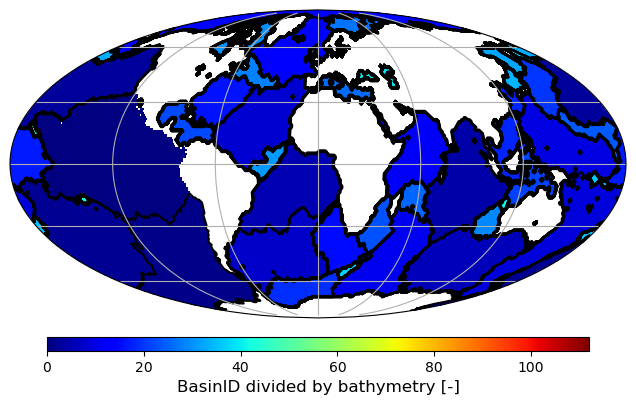

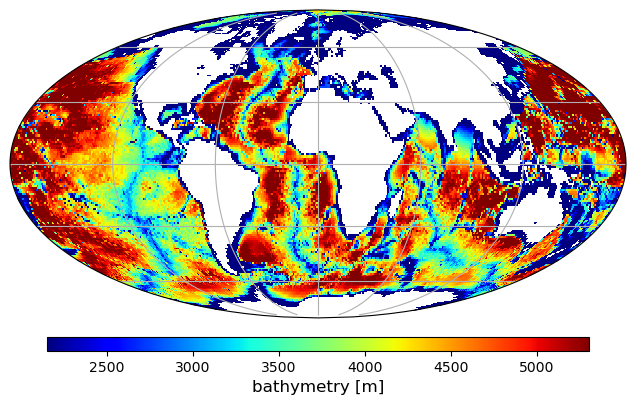

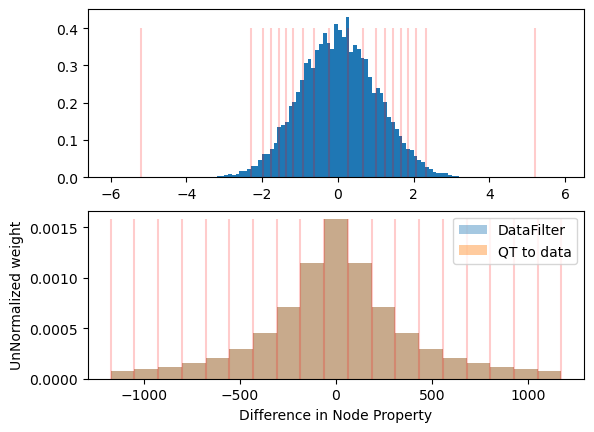

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 778.55it/s]


len(LDcommunities) 80
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_7

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4355.26it/s]


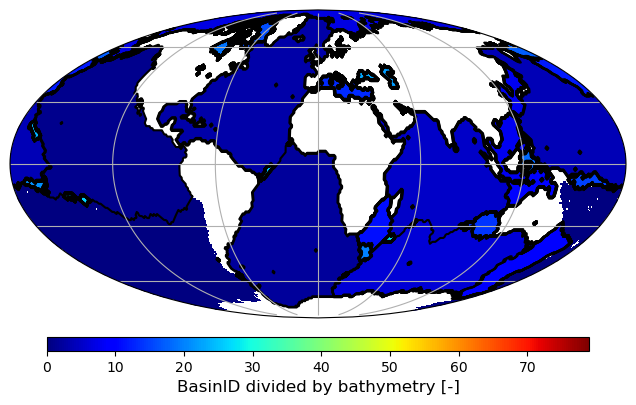

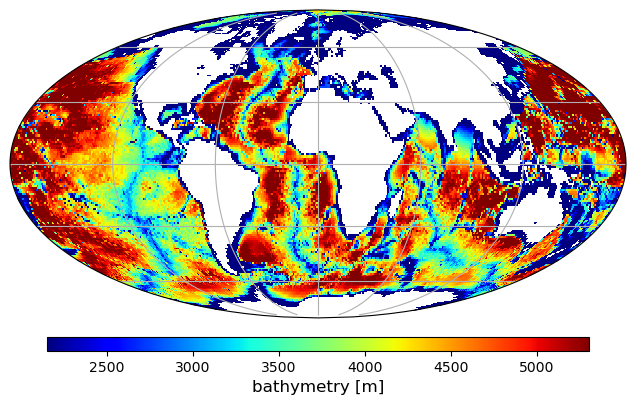

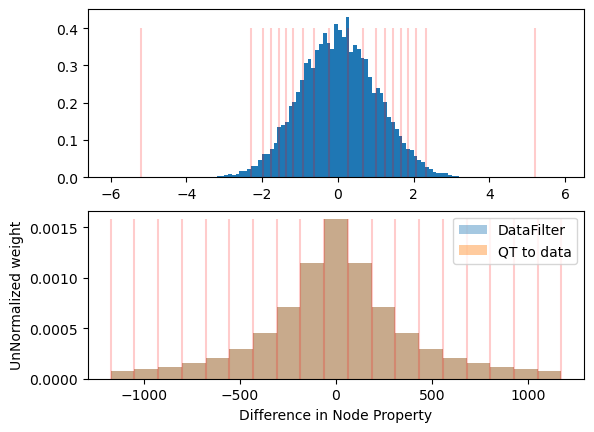

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 769.55it/s]


len(LDcommunities) 93
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_8

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:06<00:00, 4065.14it/s]


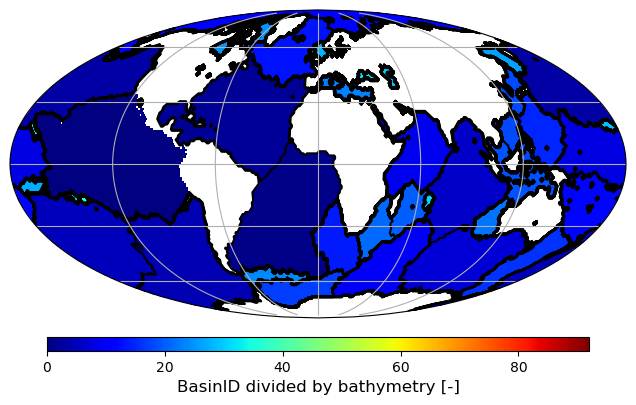

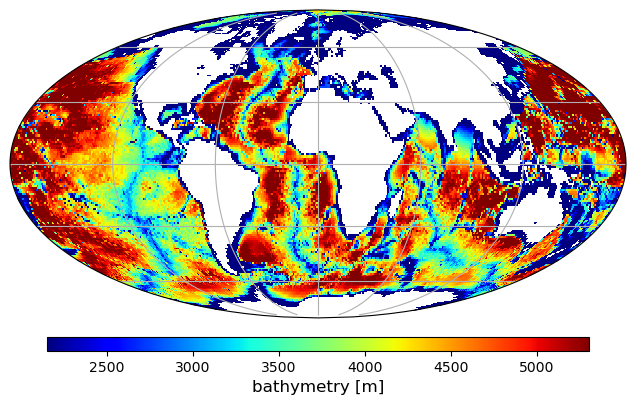

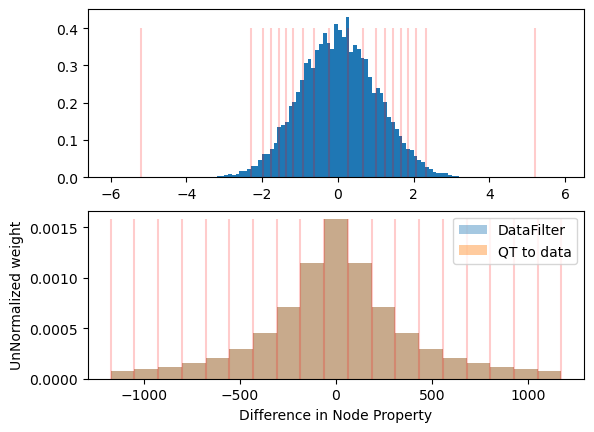

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 773.67it/s]


len(LDcommunities) 110
Network has been overwritten.


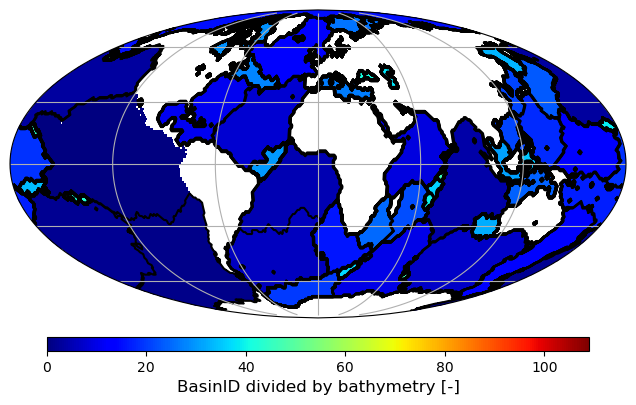

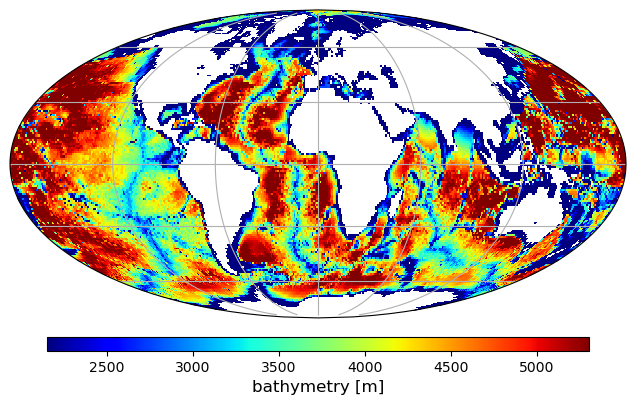

In [1]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset

# Create nodeclustering object for community evaluation
from cdlib import evaluation
from cdlib import NodeClustering


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
communityDetectionMethod = "Leiden"

# Define basin merging criteria
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.005, .01, 0.015, .005, .01, 0.015, .005, .01, 0.015];

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [12, 12, 12, 12, 12, 12, 12, 12, 12]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [1, 1, 1, 10, 10, 10, 50, 50, 50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

    
# Make base directory
directory_name = os.getcwd()+"/figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble"
os.makedirs(directory_name, exist_ok=True)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results
    fldName = EC.utils.makeFolderSeries(fldBase='figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run')
    print("Storing images in {}".format(fldName))
    
    # Short readme text to write to folder with images
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
    readmetxt += "\n{} ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)
    
    
    ###########################################
    ### Report community evaluation metrics ###
    ###########################################
    
    # Create node cluster
    # Note that the small basin mergers are not inlcuded
    # in the LGNClusters. Only large basin mergers such that
    # small basin mergers results in X chosen basins.
    LeidenClusters=NodeClustering(communities=basins.LDcommunities,
                           graph=basins.G,
                           method_name="consensus_ledien_fixed",
                           method_parameters={
                               "resolution_parameter": resolution,
                               "runs": ensembleSize,
                               "distance_threshold": 0.3}
                          )


    # Calculate community detection metrics
    for cluster, method in zip([LeidenClusters], ["LeidenClusters"]):
        newman_girvan_modularity = evaluation.newman_girvan_modularity(basins.G, cluster)
        internal_edge_density = evaluation.internal_edge_density(basins.G, cluster)
        erdos_renyi_modularity= evaluation.erdos_renyi_modularity(basins.G, cluster)
        modularity_density    = evaluation.modularity_density(basins.G, cluster)
        avg_embeddedness      = evaluation.avg_embeddedness(basins.G, cluster)
        conductance           = evaluation.conductance(basins.G, cluster)
        surprise              = evaluation.surprise(basins.G, cluster)

        # Add community evaluation metrics to output
        readmetxt += "\n\nCommunity evaluation metrics ({}):\n".format(method);
        readmetxt += "newman_girvan_modularity:\t {}\n".format(newman_girvan_modularity.score)
        readmetxt += "erdos_renyi_modularity:\t\t {}\n".format(erdos_renyi_modularity.score)
        readmetxt += "modularity_density:\t\t {}\n".format(modularity_density.score)
        readmetxt += "internal_edge_density:\t\t {} +- {} (std)\n".format(internal_edge_density.score, internal_edge_density.std)
        readmetxt += "avg_embeddedness:\t\t {} +- {} (std)\n".format(avg_embeddedness.score, avg_embeddedness.std)
        readmetxt += "conductance:\t\t\t {} +- {} (std)\n".format(conductance.score, conductance.std)
        readmetxt += "surprise:\t\t\t {}\n".format(surprise.score)
        
    
    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)



# Figure

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.035 1 12
0.04 1 12
0.045 1 12
0.035 10 12
0.04 10 12
0.045 10 12
0.035 50 12
0.04 50 12
0.045 50 12
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_18

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4257.04it/s]


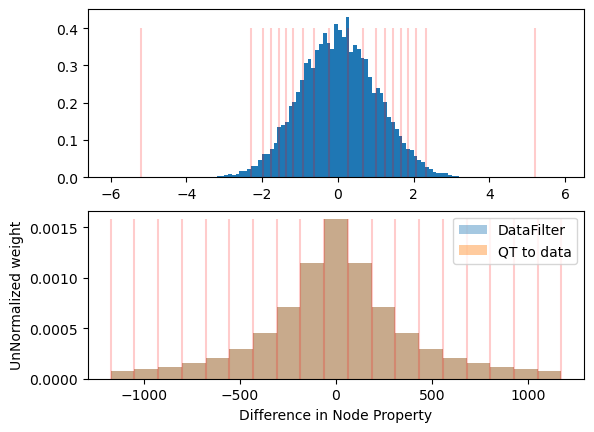

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:30<00:00, 788.63it/s]


len(LDcommunities) 82
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_19

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4243.15it/s]


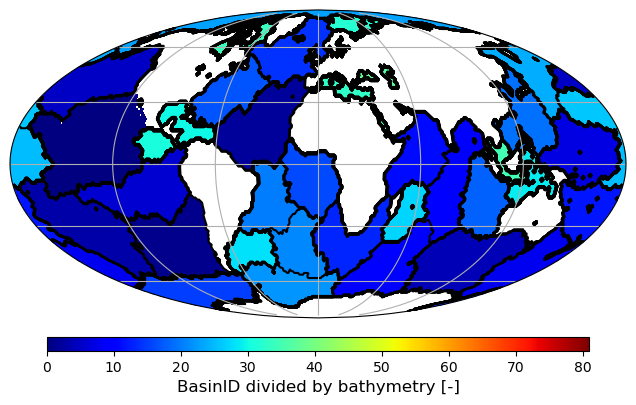

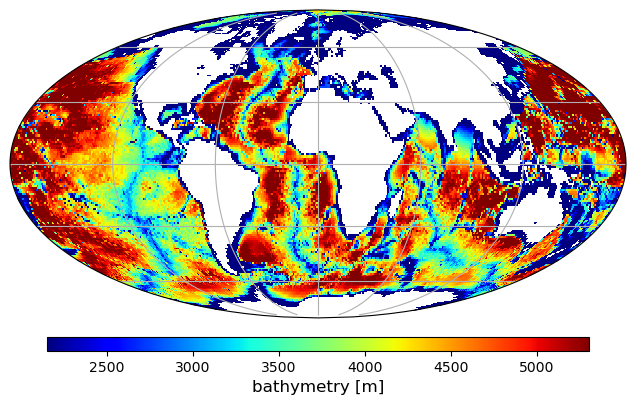

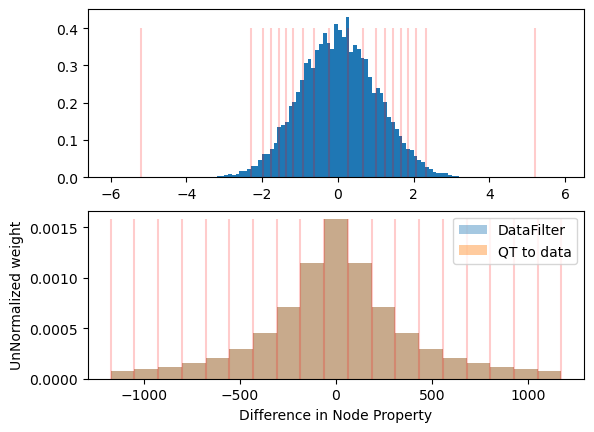

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 773.50it/s]


len(LDcommunities) 82
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_20

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4395.80it/s]


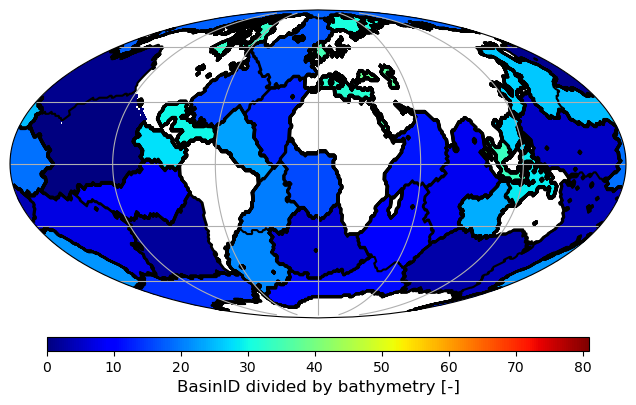

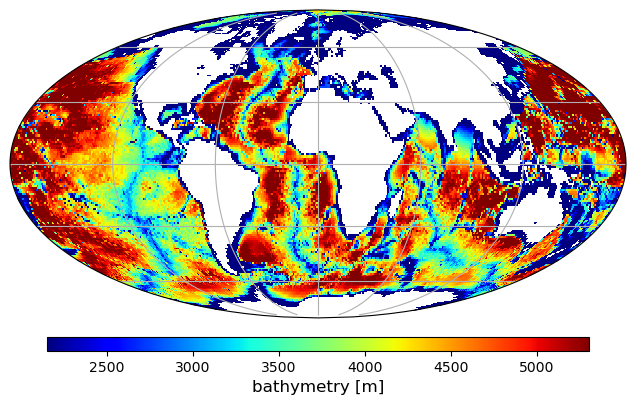

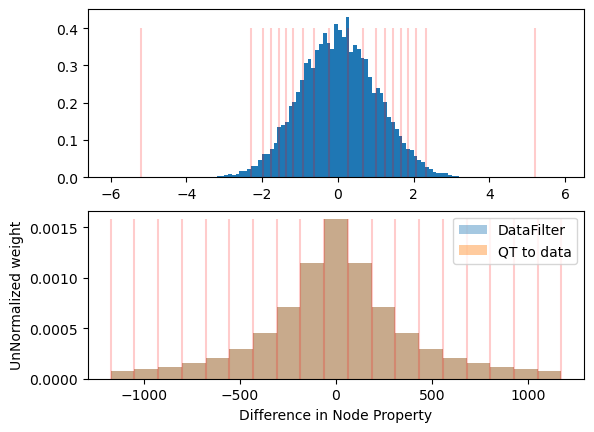

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 786.43it/s]


len(LDcommunities) 87
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_21

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4459.62it/s]


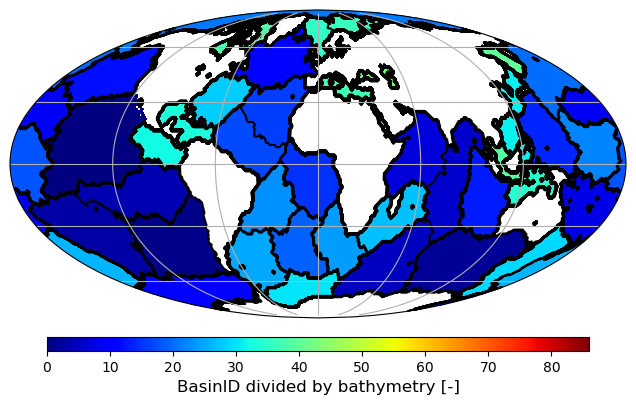

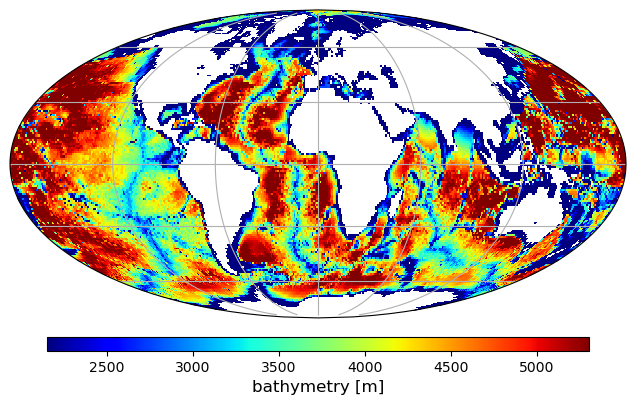

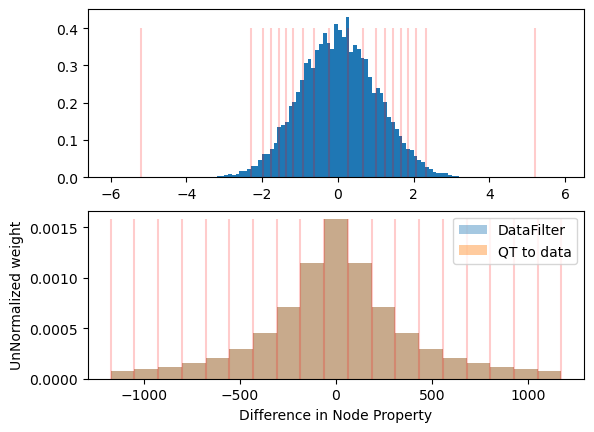

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 776.57it/s]


len(LDcommunities) 156
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_22

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4353.02it/s]


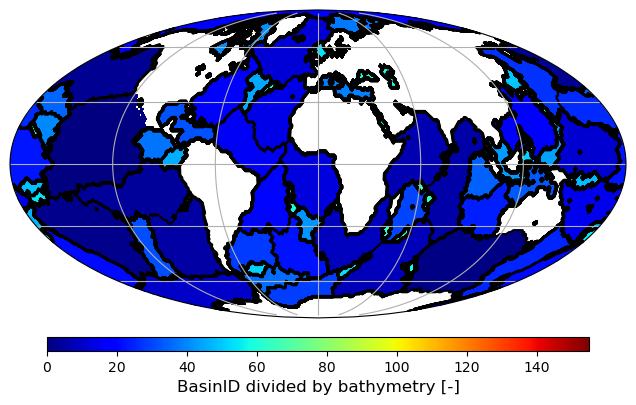

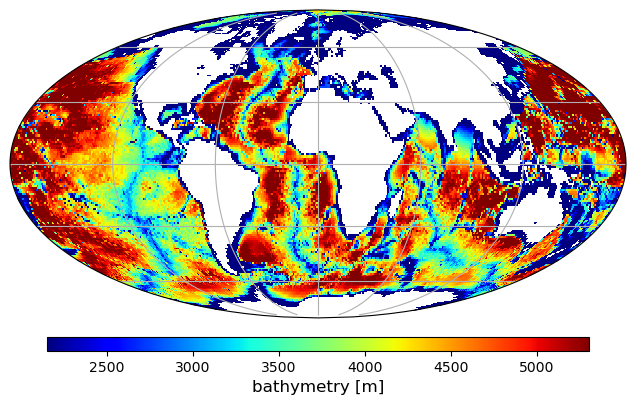

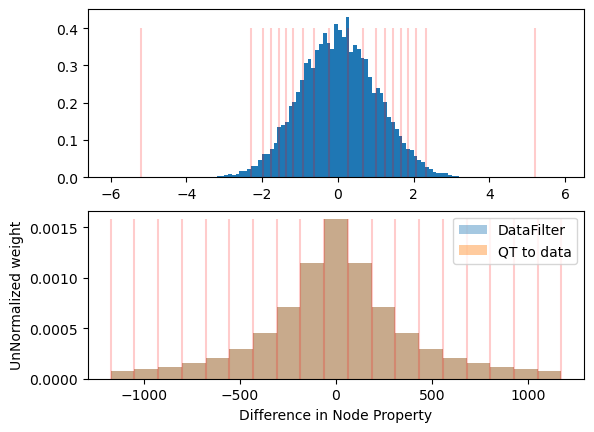

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 765.65it/s]


len(LDcommunities) 160
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_23

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:05<00:00, 4337.89it/s]


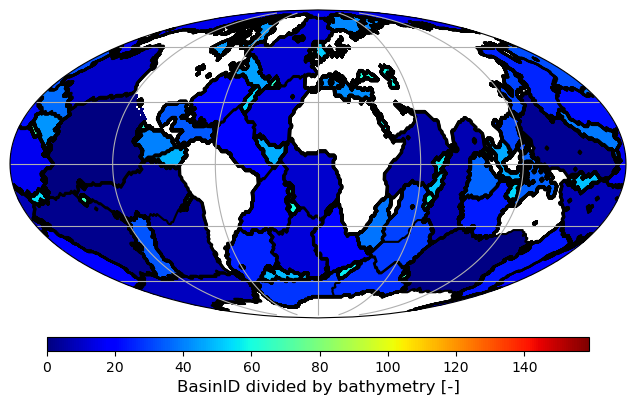

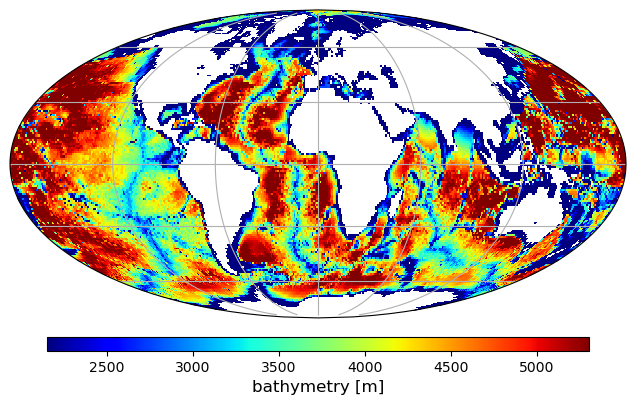

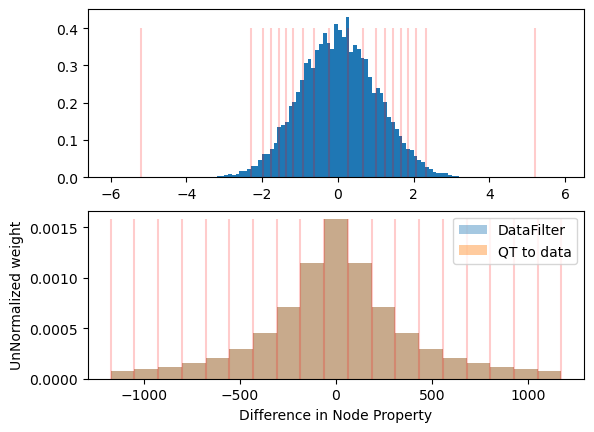

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24441/24441 [00:31<00:00, 772.26it/s]


len(LDcommunities) 162
Network has been overwritten.
Storing images in figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run_24

All fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry


Used fields
---------------
Field1
	dataGrid: /home/bogumil/Documents/External_fids/ExoCcycle-workspace/bathymetries/Earth/Earth_resampled_1deg.nc
	parameter: bathymetry
	parameterUnit: m
	parameterName: bathymetry



/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:9320: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


In [ ]:
#################################################
#################### Imports ####################
#################################################
import os
import ExoCcycle as EC
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from netCDF4 import Dataset

# Create nodeclustering object for community evaluation
from cdlib import evaluation
from cdlib import NodeClustering


#########################################
### Define Community Detection Inputs ###
#########################################
# Set the detection method
communityDetectionMethod = "Leiden"

# Define basin merging criteria
mergerPackageName = "None"; # ['threshold'] = [0]

# Define basin merging criteria
mergerPackage = EC.utils.mergerPackages(mergerPackageName);
mergerPackage['verbose'] = False;

# Resolution for quality function
resolutions = [.035, .04, 0.045];

# Minimum number of basins to have in output (only used for
# girvan-newman or composite algorithms)
minBasinCnts = [12, 12, 12]

# Set the ensemble size to use for the first part of the composite community detection
# This part runs Louvain or Leiden algorithms to reduce the network complexity. Setting
# a non-one ensemble ensures that community structure is robust given inherent randomness
# of initial node clustering. Note that ensembles of size 100 for 1 degree resolution data
# only increase total computational time by 1-2 minutes.
ensembleSizes = [50, 50, 50];


# Show the resolution, ensembleSize, and minBasinCnt used for community detection
# runs. Note that only one community detection is run here.
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    print(resolution, ensembleSize, minBasinCnt)

    
# Make base directory
directory_name = os.getcwd()+"/figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble"
os.makedirs(directory_name, exist_ok=True)

# Run for multiple resolution, ensembleSize, and minBasinCnt
for resolution, ensembleSize, minBasinCnt in zip(resolutions, ensembleSizes, minBasinCnts):
    detectionMethod = {"method":communityDetectionMethod,
                       "resolution":resolution,
                       "minBasinCnt":minBasinCnt,
                       "ensembleSize":ensembleSize,
                       "minBasinLargerThanSmallMergers":False,
                       "mergerPackage":mergerPackage}

    # Set the edge weight scheme for node connections
    # Options:
    #    "useGlobalDifference", "useEdgeDifference", "useEdgeGravity"
    #    "useLogistic", "useNormPDFFittedSigmoid", "useQTGaussianSigmoid"
    #    "useQTGaussianShiftedGaussianWeightDistribution"
    edgeWeightMethod = {"method":"useQTGaussianShiftedGaussianWeightDistribution",
                       "shortenFactor": 5,
                       "shiftFactor": .5,
                       "minWeight": 0.01}

    # Make folder to hold figure results
    fldName = EC.utils.makeFolderSeries(fldBase='figures/GMD_Manuscript/CodeOutputs/SensitivityMethodLeidenGammaEnsemble/Run')
    print("Storing images in {}".format(fldName))
    
    # Short readme text to write to folder with images
    readmetxt = "Note that the Bathymetry values are shown with a colorbar that represents 1 std that are area weighted.";
    readmetxt += "\nUsing model S <- QTG with useQTGaussianShiftedGaussianWeightDistribution (cdfCenter  = qtDissSTD*{0} and cdfStretch = qtDissSTD/{1}) for edge weights".format(edgeWeightMethod["shiftFactor"], edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nUsing S/distanceV edge weight";
    readmetxt += "\nWhere S = 1-CDF(difference), CDF=cumulative density function.";
    readmetxt += "\nWhere difference = values1-values2, the differnce between node property value after a Quantile Transformation values1-values2.";
    readmetxt += "\nThe CDF used for S is calculated as follows:";
    readmetxt += "\nThe absolute value of node values differences are collected into a vector (dataEdgeDiff).";
    readmetxt += "\nOutliers removed using the IQR method to make a filtered dataset (dataEdgeDiffIQRFiltered).";
    readmetxt += "\ndataEdgeDiffIQRFiltered (all positive) is mirror about 0 (symmetric about 0) is converted to a gaussian (z-score space) using a Quantile Transformation.";
    readmetxt += "\nThe distribution (dist1) of differences in gaussian (z-score space) is used to construct a CDF function";
    readmetxt += "\nA new distribution created from dist1 by offsetting it by 1 sigma_dist1 and shortening it by setting a new 1 sigma_dist2 of sigma_dist1/{}".format(edgeWeightMethod["shortenFactor"]);
    readmetxt += "\nThen |difference| of node properties can be expressed in z-score space and S can be calculated as S = 1-CDF(difference)";
    readmetxt += "\nThe minimum weight for this method is set to {}".format(edgeWeightMethod['minWeight']);
    readmetxt += "\nUsing {} algorithm".format(detectionMethod["method"]);
    readmetxt += "\n{} resolution: {}".format(detectionMethod["method"], detectionMethod["resolution"]);
    readmetxt += "\n{} ensemble size: {}".format(detectionMethod["method"], detectionMethod["ensembleSize"]);
    readmetxt += "\nGirvan-Newman minimum unisolated basins: {}".format(detectionMethod['minBasinCnt']);
    readmetxt += "\nCommunity merger package is EC.utils.mergePackage(package='{}')".format(mergerPackageName);


    #################################################################
    ### Create basin object and set Field for Community detection ###
    #################################################################

    # Create basin object
    body = ["Earth", "Mars", "Venus", "Moon"]
    body = body[0]
    basins = EC.utils.BasinsEA(dataDir=os.getcwd()+"/bathymetries/{}".format(body),
                             filename="{}_resampled_1deg.nc".format(body),
                             body=body);


    # Assign fields to use in community detection
    basins.useFields(fieldList=np.array(["Field1"]))

    # Show all fields stored in basins object
    basins.getFields(usedFields = False)

    # Show all fields stored in basins object that will be used
    # for community detection.
    basins.getFields(usedFields = True)


    #########################################
    ### Run Community Detection Algorithm ###
    #########################################

    # Define basins based on user input boundaries.
    # For the Louvain-Girvan-Newman composite algorithm the variable
    # minBasinCnt refers to the number of basins to maintain that are
    # not completely isolated after running the louvain algorithm.
    basins.defineBasins(detectionMethod = detectionMethod,
                        edgeWeightMethod = edgeWeightMethod,
                        reducedRes={"on":True,"factor":1},
                        read=False,
                        write=True,
                        verbose=False)


    # Merge communities based off criteria 
    basins.applyMergeBasinMethods(mergerID=0, mergerPackage=mergerPackage)

    # Convert basinID equal area grid to regular grid
    basins.interp2regularGrid(mask=True)


    #####################################
    ### Plot results of community IDs ###
    #####################################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.BasinIDA,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal.png",
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[0,np.nanmax(basins.BasinIDA)]},
                        pltOpts={"valueType": "BasinID divided by {}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "-",
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "plotIntegerContours":True,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)

    # Calculate area weighted average and standard deviation (for plotting)
    areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=basins.Fields["Field1"]['resolution'],
                                                                                              LonStEd = [np.min(basins.lon),np.max(basins.lon)+basins.Fields["Field1"]['resolution']],
                                                                                              LatStEd = [np.min(basins.lat),np.max(basins.lat)+basins.Fields["Field1"]['resolution']])
    ave, std = EC.utils.weightedAvgAndStd(basins.bathymetry, areaWeights)

    #########################
    ### Plot input fields ###
    #########################
    EC.utils.plotGlobal(basins.lat, basins.lon, basins.bathymetry,
                        outputDir = os.getcwd()+"/"+fldName,
                        fidName = "plotGlobal_{0}.png".format(basins.Fields["Field1"]['parameterName']),
                        cmapOpts={"cmap":"jet",
                                  "cbar-title":"cbar-title",
                                  "cbar-range":[ave-1*std,
                                                ave+1*std]},
                        pltOpts={"valueType": "{0}".format(basins.Fields["Field1"]['parameterName']),
                                 "valueUnits": "{}".format(basins.Fields["Field1"]['parameterUnit']),
                                 "plotTitle":"",
                                 "plotZeroContour":False,
                                 "transparent":True},
                        savePNG=True,
                        saveSVG=False)
    
    
    ###########################################
    ### Report community evaluation metrics ###
    ###########################################
    
    # Create node cluster
    # Note that the small basin mergers are not inlcuded
    # in the LGNClusters. Only large basin mergers such that
    # small basin mergers results in X chosen basins.
    LeidenClusters=NodeClustering(communities=basins.LDcommunities,
                           graph=basins.G,
                           method_name="consensus_ledien_fixed",
                           method_parameters={
                               "resolution_parameter": resolution,
                               "runs": ensembleSize,
                               "distance_threshold": 0.3}
                          )


    # Calculate community detection metrics
    for cluster, method in zip([LeidenClusters], ["LeidenClusters"]):
        newman_girvan_modularity = evaluation.newman_girvan_modularity(basins.G, cluster)
        internal_edge_density = evaluation.internal_edge_density(basins.G, cluster)
        erdos_renyi_modularity= evaluation.erdos_renyi_modularity(basins.G, cluster)
        modularity_density    = evaluation.modularity_density(basins.G, cluster)
        avg_embeddedness      = evaluation.avg_embeddedness(basins.G, cluster)
        conductance           = evaluation.conductance(basins.G, cluster)
        surprise              = evaluation.surprise(basins.G, cluster)

        # Add community evaluation metrics to output
        readmetxt += "\n\nCommunity evaluation metrics ({}):\n".format(method);
        readmetxt += "newman_girvan_modularity:\t {}\n".format(newman_girvan_modularity.score)
        readmetxt += "erdos_renyi_modularity:\t\t {}\n".format(erdos_renyi_modularity.score)
        readmetxt += "modularity_density:\t\t {}\n".format(modularity_density.score)
        readmetxt += "internal_edge_density:\t\t {} +- {} (std)\n".format(internal_edge_density.score, internal_edge_density.std)
        readmetxt += "avg_embeddedness:\t\t {} +- {} (std)\n".format(avg_embeddedness.score, avg_embeddedness.std)
        readmetxt += "conductance:\t\t\t {} +- {} (std)\n".format(conductance.score, conductance.std)
        readmetxt += "surprise:\t\t\t {}\n".format(surprise.score)
        
    
    with open(fldName+"/readme.txt", "w") as text_file:
        text_file.write(readmetxt)

